## Exploratory Data Analysis (EDA)

In [216]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use('ggplot')

from datetime import datetime, timedelta
from geopy import distance

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN

from scipy.stats import skew, ttest_ind


In [217]:
# load the pickle file
train_cleaned = pd.read_pickle('../datasets/train_cleaned.pkl')

In [218]:
train_cleaned.shape

(1296675, 30)

In [219]:
train_cleaned.columns

Index(['trans_datetime', 'cc_num', 'merchant', 'category', 'amt', 'gender',
       'street', 'city', 'state', 'zip', 'lat', 'long', 'city_pop', 'job',
       'trans_num', 'merch_lat', 'merch_long', 'is_fraud', 'name',
       'coords_ori', 'coords_merch', 'trans_year', 'trans_month', 'trans_week',
       'trans_day', 'trans_hour', 'trans_minute', 'trans_dayofweek', 'age',
       'distance'],
      dtype='object')

In [220]:
# One glance view of the datasets - Super Imbalance Datasets
train_cleaned['is_fraud'].value_counts(normalize=True)

0    0.994211
1    0.005789
Name: is_fraud, dtype: float64

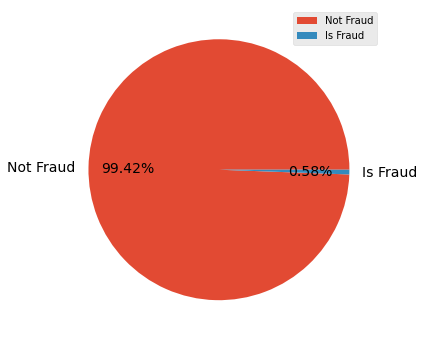

In [221]:
plt.figure(figsize=(6,6))
plt.pie(train_cleaned['is_fraud'].value_counts(normalize=True), 
         labels = ['Not Fraud','Is Fraud'], autopct='%.2f%%', pctdistance=0.7, textprops={'fontsize': 14})
plt.legend();

We able to see clearly that our datasets is super imbalanced with only 0.58% of transactions are Fraud.

In [222]:
# check transctions that occur same time by same credit card
train_cleaned.groupby(['cc_num','is_fraud','trans_datetime'])['cc_num'].count()\
[train_cleaned.groupby(['cc_num','is_fraud','trans_datetime'])['cc_num'].count()>1]

cc_num               is_fraud  trans_datetime     
581686439828         0         2019-08-26 21:47:51    2
630423337322         0         2019-12-08 14:36:51    2
676173792455         0         2019-12-14 01:11:03    2
180036456789979      0         2019-08-11 19:26:21    2
374930071163758      0         2019-06-16 23:58:35    2
375082648741747      0         2019-06-28 21:25:50    2
2383461948823908     0         2019-12-06 08:43:10    2
3506042666828517     0         2019-04-18 17:32:31    2
3517527805128735     0         2020-03-14 02:15:53    2
3533012926413100     0         2020-05-21 15:52:29    2
3553629419254918     0         2019-03-10 02:31:27    2
3560318482131952     0         2019-10-31 01:16:14    2
3595192916105588     0         2019-01-16 05:51:27    2
4904681492230012     0         2020-03-15 00:34:58    2
4933461930348832     0         2019-04-14 16:33:06    2
6011504998544485     0         2019-09-23 16:43:49    2
6011652924285713     0         2020-06-02 20:14:33   

No Fraud Transaction is found from the transactions that occur at the same time by using the same credit card

In [223]:
# check Correlationship against Target
train_cleaned.corr()['is_fraud'].sort_values(ascending=False)[1:]

amt                0.219404
trans_hour         0.013799
age                0.012453
trans_day          0.003848
trans_year         0.003004
city_pop           0.002136
lat                0.001894
merch_lat          0.001741
trans_dayofweek    0.001739
merch_long         0.001721
long               0.001721
trans_minute       0.001033
distance           0.000404
trans_week        -0.012183
trans_month       -0.012409
Name: is_fraud, dtype: float64

From the Pearson Correlation Coefficient, we can only find that `amt` have moderately positive correlation against Target. The rest of the features have weak correlation against Target

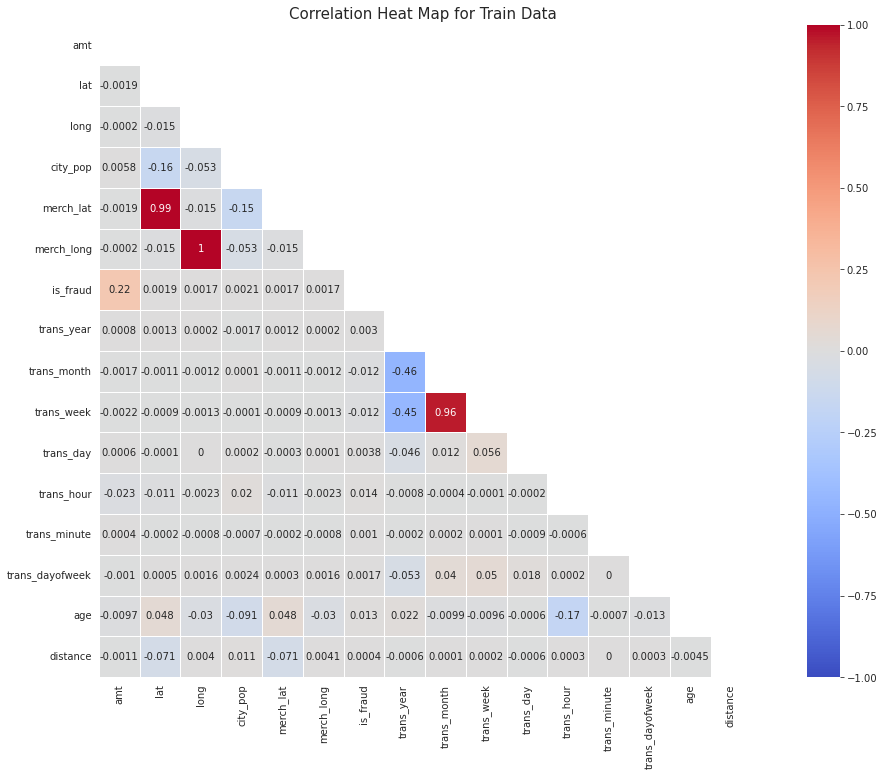

In [224]:
# Use Heatmap to show the correlation on df_act_sat_wide
plt.figure(figsize = (20,12))

# Get correlation of variables.
corr = round(train_cleaned.corr(),4)

# Set up mask to be "True" in the upper triangle.
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True

# Plot our correlation heatmap, while masking the upper triangle to be white.
with sns.axes_style("white"):
    sns.heatmap(corr, mask = mask, square = True, annot = True, vmin = -1, vmax = 1, linewidths = .5, cmap='coolwarm') 
                #cbar_kws={'orientation': 'horizontal'})
    
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.title('Correlation Heat Map for Train Data ',fontsize=15);

### EDA: Amount

In [225]:
train_cleaned['amt'].describe()

count    1.296675e+06
mean     7.035104e+01
std      1.603160e+02
min      1.000000e+00
25%      9.650000e+00
50%      4.752000e+01
75%      8.314000e+01
max      2.894890e+04
Name: amt, dtype: float64

In [226]:
print(f"Median: {train_cleaned['amt'].median()}")
print(f"Mode: {train_cleaned['amt'].mode().values[0]}")
print(f"Skewnewss: {skew(train_cleaned['amt'])}")

Median: 47.52
Mode: 1.14
Skewnewss: 42.2778248827837


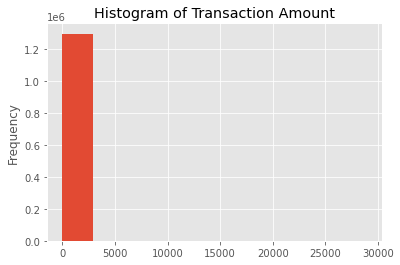

In [227]:
train_cleaned['amt'].plot(kind='hist')
plt.title('Histogram of Transaction Amount');

In [228]:
train_cleaned.groupby(['is_fraud']).agg({'amt':['sum','count','mean','median']})

amt                              
                  sum    count        mean   median
is_fraud                                           
0         87234340.29  1289169   67.667110   47.280
1          3988088.61     7506  531.320092  396.505

From our datasets, it shows total of __3,988,088.61__ is fraud transactions, with higher average amount of transation and median of transaction amount.

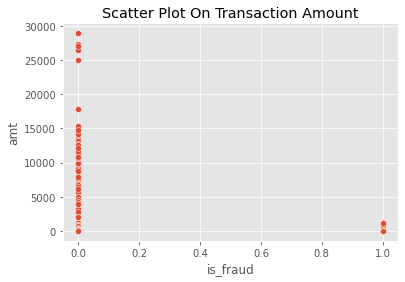

In [229]:
sns.scatterplot(data=train_cleaned, x='is_fraud', y='amt')
plt.title('Scatter Plot On Transaction Amount');

The scatter plot does not shows strong sign of relationships between amount and fraud transactions.

In [230]:
# check stats of `amt` with no fraud
print(f"Median: {train_cleaned[train_cleaned['is_fraud']==0]['amt'].median()}")
print(f"Mode: {train_cleaned[train_cleaned['is_fraud']==0]['amt'].mode().values[0]}")
print(f"Skewnewss: {skew(train_cleaned[train_cleaned['is_fraud']==0]['amt'])}")

Median: 47.28
Mode: 1.14
Skewnewss: 47.523710040158775


In [231]:
# check stats of `amt` with fraud
print(f"Median: {train_cleaned[train_cleaned['is_fraud']==1]['amt'].median()}")
print(f"Mode: {train_cleaned[train_cleaned['is_fraud']==1]['amt'].mode().values[0]}")
print(f"Skewnewss: {skew(train_cleaned[train_cleaned['is_fraud']==1]['amt'])}")

Median: 396.505
Mode: 8.75
Skewnewss: 0.025840918652551528


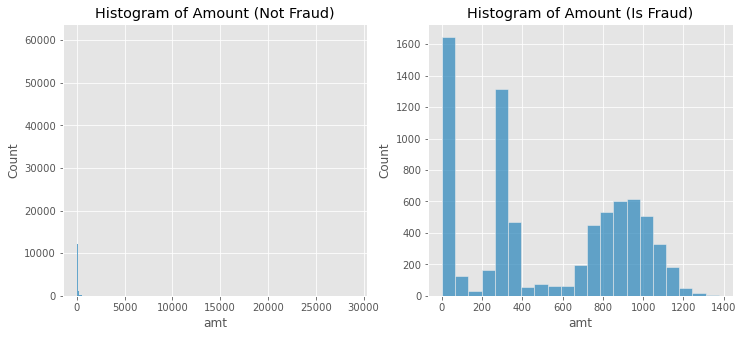

In [232]:
fig, ax = plt.subplots(1,2, figsize=(12,5))
sns.histplot(ax= ax[0],data= train_cleaned[train_cleaned['is_fraud']==0] , x='amt')
ax[0].set_title('Histogram of Amount (Not Fraud)')
sns.histplot(ax= ax[1],data= train_cleaned[train_cleaned['is_fraud']==1] , x='amt')
ax[1].set_title('Histogram of Amount (Is Fraud)');

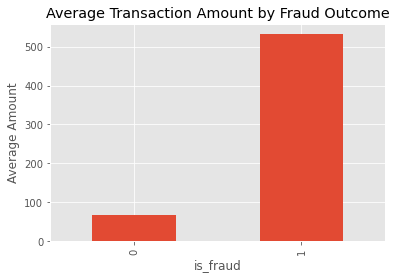

In [233]:
train_cleaned.groupby(['is_fraud']).mean()['amt'].plot(kind='bar')
plt.ylabel('Average Amount')
plt.title('Average Transaction Amount by Fraud Outcome');

In [234]:
# check statistical significant
mean_amt_fraud = train_cleaned[train_cleaned['is_fraud'] == 1]['amt']
mean_amt_non_fraud = train_cleaned[train_cleaned['is_fraud'] == 0]['amt']

ttest_ind(mean_amt_fraud, mean_amt_non_fraud)

Ttest_indResult(statistic=256.07818064818656, pvalue=0.0)

Our pvalue is less than 0.05, which indicate the mean amount for fraud and non fraud are statistical significant.

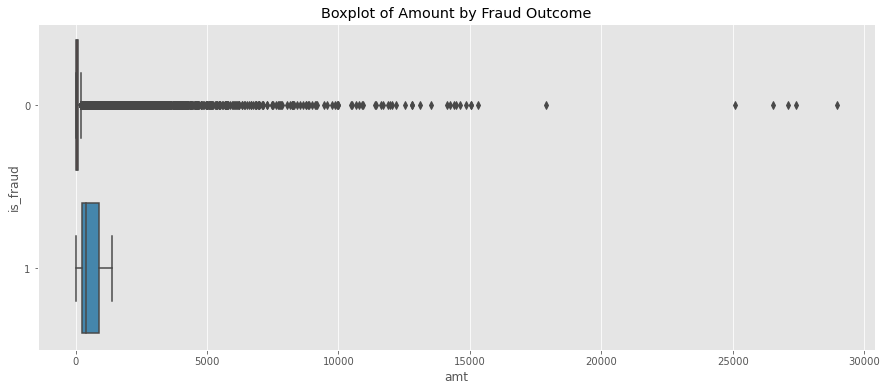

In [235]:
# plot boxplot on `amt`
plt.figure(figsize=(15,6))
sns.boxplot(data=train_cleaned, y='is_fraud', x='amt', orient='h')
plt.title('Boxplot of Amount by Fraud Outcome');

42.2778248827837
-0.4486387131679679


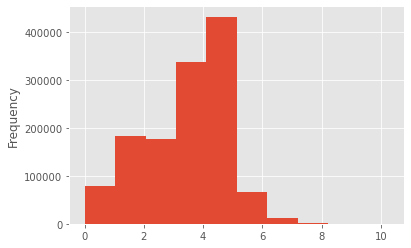

In [236]:
print(skew(train_cleaned['amt']))
print(skew(np.log(train_cleaned['amt'])))

np.log(train_cleaned[train_cleaned['is_fraud']==0]['amt']).plot(kind='hist');

In [237]:
# continuous variable binning
train_cleaned['amt_group'] = pd.qcut(train_cleaned['amt'], [0, 0.1, 0.25, 0.5, 0.75, 0.9, 1], 
                                     labels=['very_low', 'low', 'medium', 'above_medium','high','very_high'])

train_cleaned['amt_group'].value_counts().sort_index().to_frame().reset_index()

,index,amt_group
0,very_low,129795
1,low,194530
2,medium,324087
3,above_medium,324151
4,high,194454
5,very_high,129658


In [238]:
fraud_amt_pct = train_cleaned.groupby(['amt_group','is_fraud'])['amt_group'].count().to_frame().unstack().reset_index()['amt_group']

fraud_amt_pct['pct_of_fraud'] = fraud_amt_pct[1] / (fraud_amt_pct[1] + fraud_amt_pct[0])
fraud_amt_pct.rename(columns= {'':'amt_group'},  inplace=True)
fraud_amt_pct

is_fraud,amt_group,0,1,pct_of_fraud
0,very_low,129777,18,0.000139
1,low,194087,443,0.002277
2,medium,322983,1104,0.003406
3,above_medium,324070,81,0.000250
4,high,194318,136,0.000699
5,very_high,123934,5724,0.044147


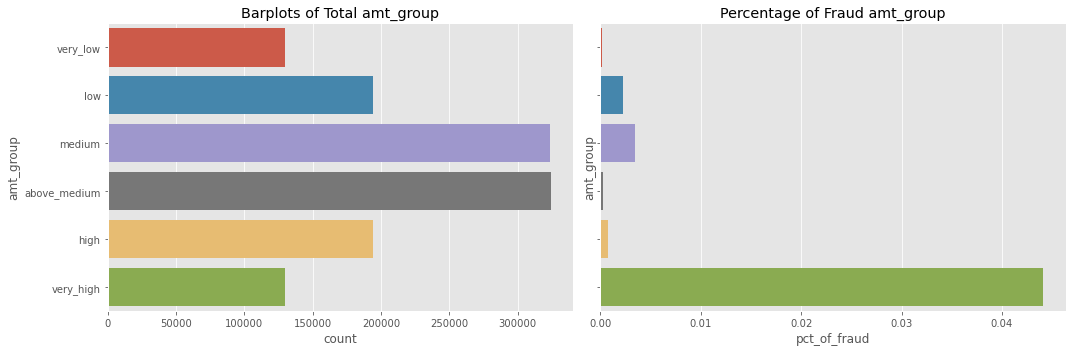

In [239]:
fig, ax = plt.subplots(ncols=2, figsize=(15,5), sharey=True)
sns.countplot(ax=ax[0], data=train_cleaned, y='amt_group', orient='h')
ax[0].set_title('Barplots of Total amt_group')

sns.barplot(ax=ax[1], data= fraud_amt_pct, x='pct_of_fraud',
            y='amt_group')
ax[1].set_title('Percentage of Fraud amt_group')

plt.tight_layout();

In [240]:
train_cleaned.groupby('amt_group').mean()['amt'].reset_index()

,amt_group,amt
0,very_low,2.482730
1,low,6.838573
2,medium,28.007673
3,above_medium,64.671748
4,high,104.571191
5,very_high,302.297231


### EDA: Age

In [241]:
train_cleaned['age'].describe()

count    1.296675e+06
mean     4.602930e+01
std      1.738237e+01
min      1.400000e+01
25%      3.300000e+01
50%      4.400000e+01
75%      5.700000e+01
max      9.600000e+01
Name: age, dtype: float64

In [242]:
print(f"Median: {train_cleaned['age'].median()}")
print(f"Mode: {train_cleaned['age'].mode().values[0]}")
print(f"Skewnewss: {skew(train_cleaned['age'])}")

Median: 44.0
Mode: 47
Skewnewss: 0.6122613356350991


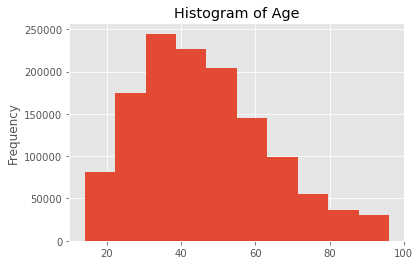

In [243]:
train_cleaned['age'].plot(kind='hist')
plt.title('Histogram of Age');

In [244]:
train_cleaned.groupby(['is_fraud']).agg({'age':['count','mean','median']})

age                 
            count      mean median
is_fraud                          
0         1289169  46.01278   44.0
1            7506  48.86624   48.0

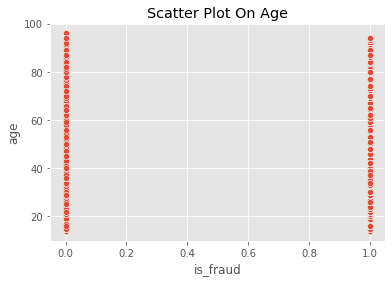

In [245]:
sns.scatterplot(data=train_cleaned, x='is_fraud', y='age')
plt.title('Scatter Plot On Age');

There is no clear sign shows that the age have clear correlation on target

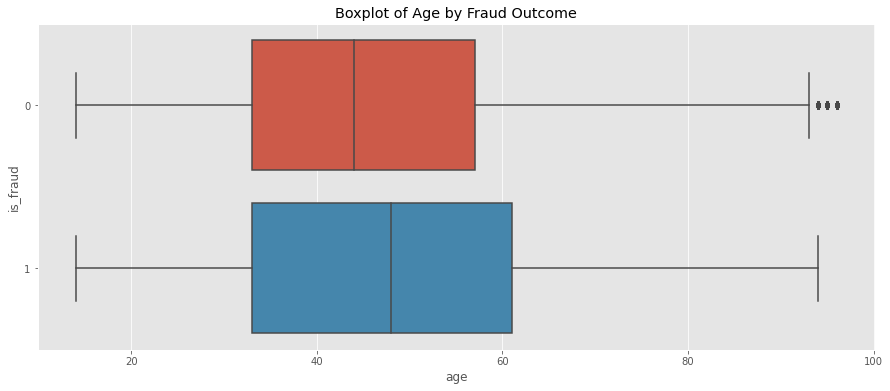

In [246]:
# plot boxplot on `age`
plt.figure(figsize=(15,6))
sns.boxplot(data=train_cleaned, y='is_fraud', x='age', orient='h')
plt.title('Boxplot of Age by Fraud Outcome');

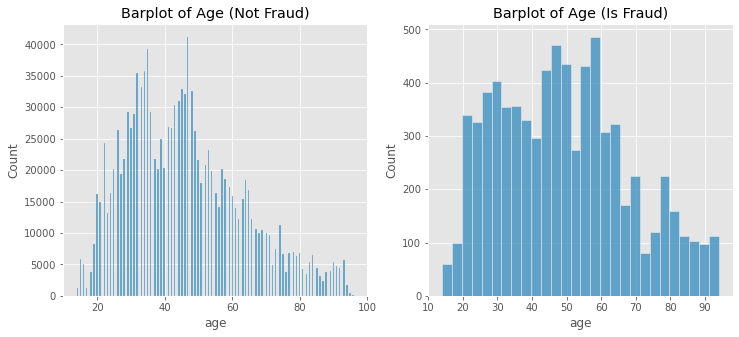

In [247]:
fig, ax = plt.subplots(1,2, figsize=(12,5))
sns.histplot(ax= ax[0],data= train_cleaned[train_cleaned['is_fraud']==0] , x='age')
ax[0].set_title('Barplot of Age (Not Fraud)')
sns.histplot(ax= ax[1],data= train_cleaned[train_cleaned['is_fraud']==1] , x='age')
ax[1].set_title('Barplot of Age (Is Fraud)');

In [248]:
# check stats of `age` with no fraud
print(f"Median: {train_cleaned[train_cleaned['is_fraud']==0]['age'].median()}")
print(f"Mode: {train_cleaned[train_cleaned['is_fraud']==0]['age'].mode().values[0]}")
print(f"Skewnewss: {skew(train_cleaned[train_cleaned['is_fraud']==0]['age'])}")

Median: 44.0
Mode: 47
Skewnewss: 0.6136236522934941


In [249]:
# check stats of `age` with fraud
print(f"Median: {train_cleaned[train_cleaned['is_fraud']==1]['age'].median()}")
print(f"Mode: {train_cleaned[train_cleaned['is_fraud']==1]['age'].mode().values[0]}")
print(f"Skewnewss: {skew(train_cleaned[train_cleaned['is_fraud']==1]['age'])}")

Median: 48.0
Mode: 49
Skewnewss: 0.3714265712966161


In [250]:
train_cleaned['age'].min(), train_cleaned['age'].max()

(14, 96)

In [251]:
# continuous variable binning
train_cleaned['age_group'] = pd.cut(train_cleaned['age'], [13,23,33,43,53,63,73,83,93,103],
                                   labels=['below_23', '23_33', '33_43', '43_53', '53_63', '63_73','73_83','83_93','above_93'])

train_cleaned['age_group'].value_counts().sort_index().to_frame().reset_index()

,index,age_group
0,below_23,94520
1,23_33,258946
2,33_43,276334
3,43_53,280879
4,53_63,165092
5,63_73,111329
6,73_83,62533
7,83_93,44784
8,above_93,2258


In [252]:
fraud_age_pct = train_cleaned.groupby(['age_group','is_fraud'])['age_group'].count().to_frame().unstack().reset_index()['age_group']

fraud_age_pct['pct_of_fraud'] = fraud_age_pct[1] / (fraud_age_pct[1] + fraud_age_pct[0])
fraud_age_pct.rename(columns= {'':'age_group'},  inplace=True)
fraud_age_pct

is_fraud,age_group,0,1,pct_of_fraud
0,below_23,93909,611,0.006464
1,23_33,257591,1355,0.005233
2,33_43,275166,1168,0.004227
3,43_53,279460,1419,0.005052
4,53_63,163758,1334,0.008080
5,63_73,110640,689,0.006189
6,73_83,62007,526,0.008412
7,83_93,44407,377,0.008418
8,above_93,2231,27,0.011957


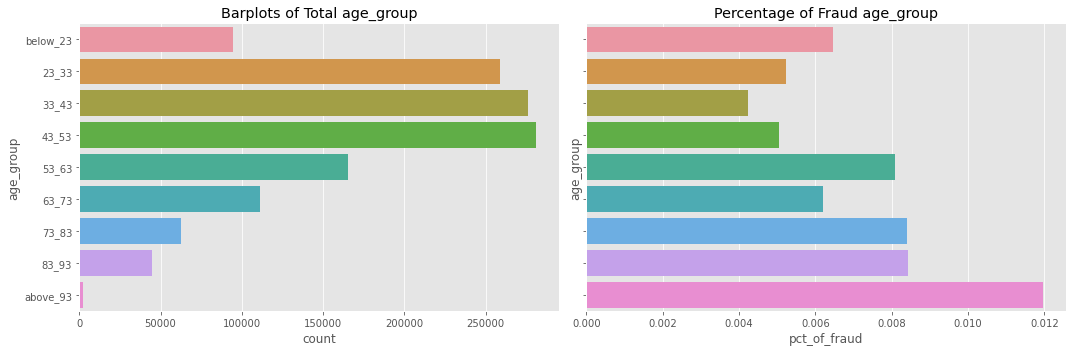

In [253]:
fig, ax = plt.subplots(ncols=2, figsize=(15,5), sharey=True)
sns.countplot(ax=ax[0], data=train_cleaned, y='age_group', orient='h')
ax[0].set_title('Barplots of Total age_group')

sns.barplot(ax=ax[1], data= fraud_age_pct, x='pct_of_fraud',
            y='age_group')
ax[1].set_title('Percentage of Fraud age_group')

plt.tight_layout();

In [254]:
train_cleaned.groupby('age_group').agg({'amt':['count','mean','median']})

amt                  
            count       mean median
age_group                          
below_23    94520  61.547462  37.35
23_33      258946  73.485529  50.86
33_43      276334  75.646570  52.55
43_53      280879  70.295723  47.46
53_63      165092  66.846857  42.98
63_73      111329  65.691314  42.51
73_83       62533  66.865218  42.33
83_93       44784  67.778349  43.40
above_93     2258  71.731501  44.58

### EDA: Gender

In [255]:
train_cleaned['gender'].value_counts(normalize=True)

F    0.547449
M    0.452551
Name: gender, dtype: float64

In [256]:
train_cleaned.groupby(['is_fraud','gender'])['amt'].mean()

is_fraud  gender
0         F          67.958395
          M          67.314331
1         F         494.052835
          M         568.231575
Name: amt, dtype: float64

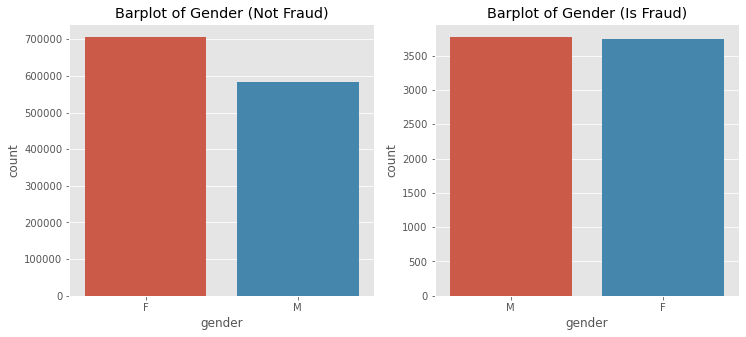

In [257]:
fig, ax = plt.subplots(1,2, figsize=(12,5))
sns.countplot(ax= ax[0],data= train_cleaned[train_cleaned['is_fraud']==0] , x='gender')
ax[0].set_title('Barplot of Gender (Not Fraud)')
sns.countplot(ax= ax[1],data= train_cleaned[train_cleaned['is_fraud']==1] , x='gender')
ax[1].set_title('Barplot of Gender (Is Fraud)');

### EDA: Credit Card

In [258]:
train_cleaned.shape

(1296675, 32)

In [259]:
train_cleaned['cc_num'].describe()

count          1296675
unique             983
top       571365235126
freq              3123
Name: cc_num, dtype: int64

In [260]:
cc_no_fraud = train_cleaned[['cc_num','is_fraud']].groupby('cc_num')['is_fraud'].mean().sort_values()\
[train_cleaned[['cc_num','is_fraud']].groupby('cc_num')['is_fraud'].mean().sort_values() == 0]

len(cc_no_fraud.index)

221

In [261]:
len(cc_no_fraud.index) / train_cleaned['cc_num'].nunique()

0.22482197355035605

There is about 22.5% of credit card without any fraud transactions

In [262]:
train_cleaned[train_cleaned['cc_num'].isin(cc_no_fraud.index)].describe()['amt']

count    319851.000000
mean         67.318519
std         154.170764
min           1.000000
25%           9.320000
50%          45.830000
75%          81.580000
max       17897.240000
Name: amt, dtype: float64

In [263]:
cc_only_fraud = train_cleaned[['cc_num','is_fraud']].groupby('cc_num')['is_fraud'].mean().sort_values()\
[train_cleaned[['cc_num','is_fraud']].groupby('cc_num')['is_fraud'].mean().sort_values() == 1]

len(cc_only_fraud.index)

75

In [264]:
len(cc_only_fraud.index) / train_cleaned['cc_num'].nunique()

0.0762970498474059

There is about 7.6% of credit card with all fraud transactions

In [265]:
train_cleaned[train_cleaned['cc_num'].isin(cc_only_fraud.index)].describe()['amt']

count     741.000000
mean      597.059528
std       398.304429
min         6.230000
25%       283.260000
50%       754.990000
75%       956.700000
max      1376.040000
Name: amt, dtype: float64

### Longitude & Latitude

In [272]:
train_cleaned['state'].nunique()

51

In [273]:
train_cleaned['city'].nunique()

894

In [274]:
train_cleaned['zip'].nunique()

970

In [275]:
train_cleaned['coords_ori'].nunique()

970

In [277]:
train_cleaned['trans_datetime'].nunique()

1274791

In [278]:
train_cleaned['trans_num'].nunique()

1296675

In [282]:
train_cleaned.groupby(['long','lat'])[['amt','city_pop']].mean().reset_index()

,long,lat,amt,city_pop
0,-165.6723,64.7556,64.013967,145.0
1,-156.2920,65.6899,67.484944,277.0
2,-155.4880,20.0827,62.384971,4878.0
3,-155.3697,20.0271,56.714957,1490.0
4,-153.9940,66.6933,650.606667,239.0
...,...,...,...,...
965,-69.9576,44.3229,53.452626,6025.0
966,-69.4828,44.0943,60.136844,1643.0
967,-69.2675,44.8393,58.848150,3228.0
968,-68.5565,44.2541,100.042968,824.0


In [283]:
train_cleaned.groupby(['long','lat'])[['amt','city_pop']].mean().reset_index()['amt'].describe()

count    970.000000
mean     110.680467
std      146.504632
min       42.951671
25%       61.071510
50%       67.543395
75%       87.683537
max      948.818182
Name: amt, dtype: float64

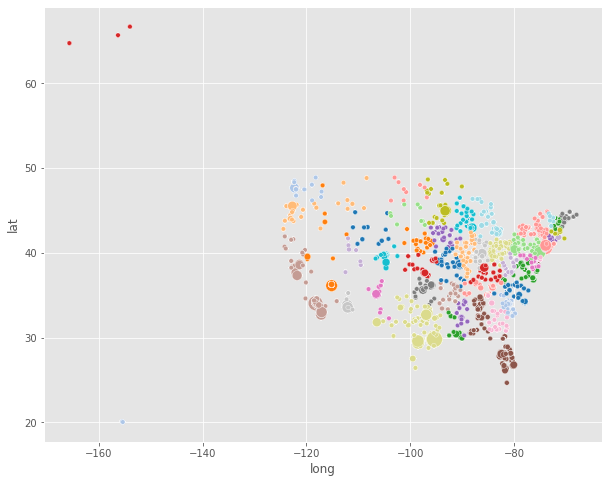

In [284]:
plt.figure(figsize=(10,8))

sns.scatterplot(data=train_cleaned[['lat','long','state','city_pop']],
                x='long' , y='lat', hue='state', legend=False , palette='tab20',
               size='city_pop',sizes= (20,250));

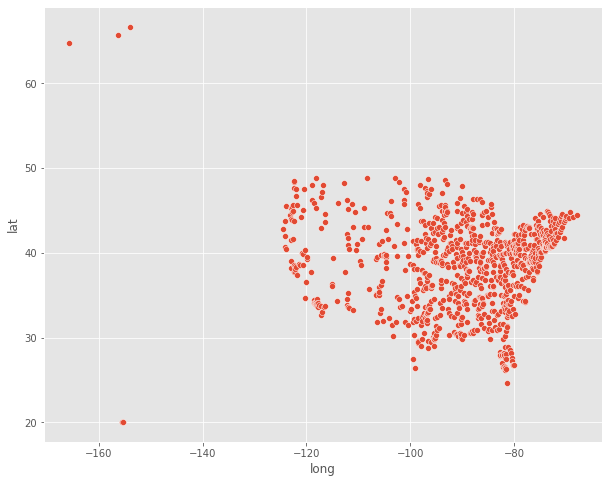

In [285]:
plt.figure(figsize=(10,8))

sns.scatterplot(data=train_cleaned.groupby(['long','lat'])[['amt','city_pop']].mean().reset_index(),
                x='long' , y='lat');

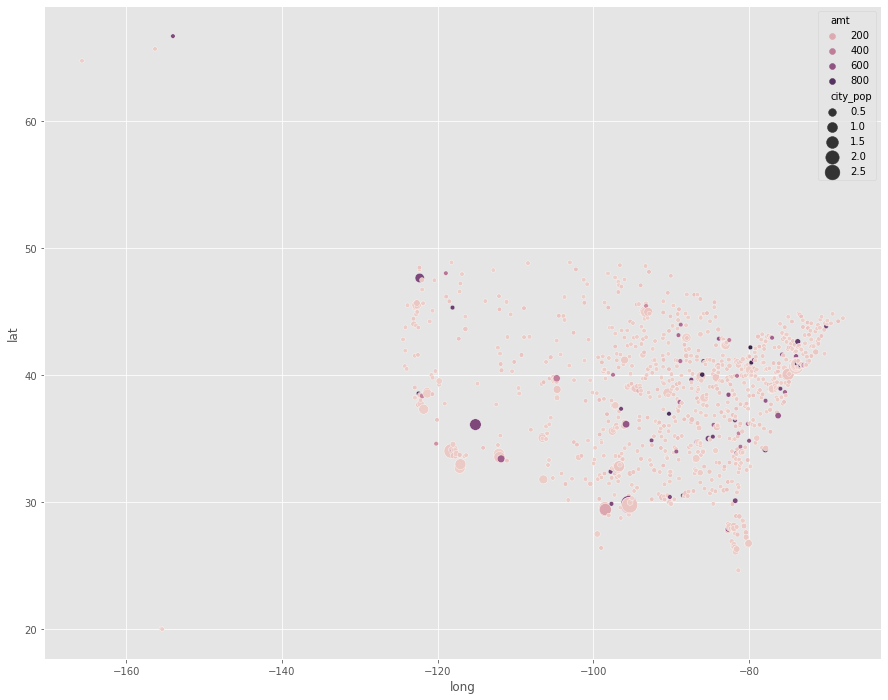

In [286]:
plt.figure(figsize=(15,12))

sns.scatterplot(data=train_cleaned.groupby(['long','lat'])[['amt','city_pop']].mean().reset_index(),
                x='long' , y='lat', size='city_pop', hue='amt', sizes= (20,250));

### City Population

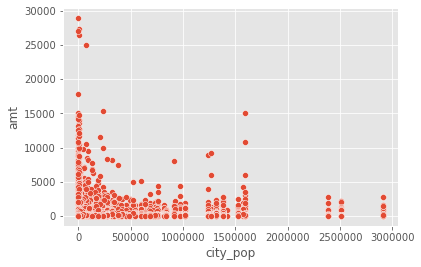

In [287]:
sns.scatterplot(data= train_cleaned,
                x='city_pop', y='amt')
plt.ticklabel_format(style='plain', axis='x');

### Category

In [288]:
order_cat_not_fraud = train_cleaned[train_cleaned['is_fraud']==0]['category'].value_counts().index
order_cat_is_fraud = train_cleaned[train_cleaned['is_fraud']==1]['category'].value_counts().index

cat_palette = ['red' if (i in range(4)) else 'grey' for i,x in enumerate(order_cat_is_fraud) ]

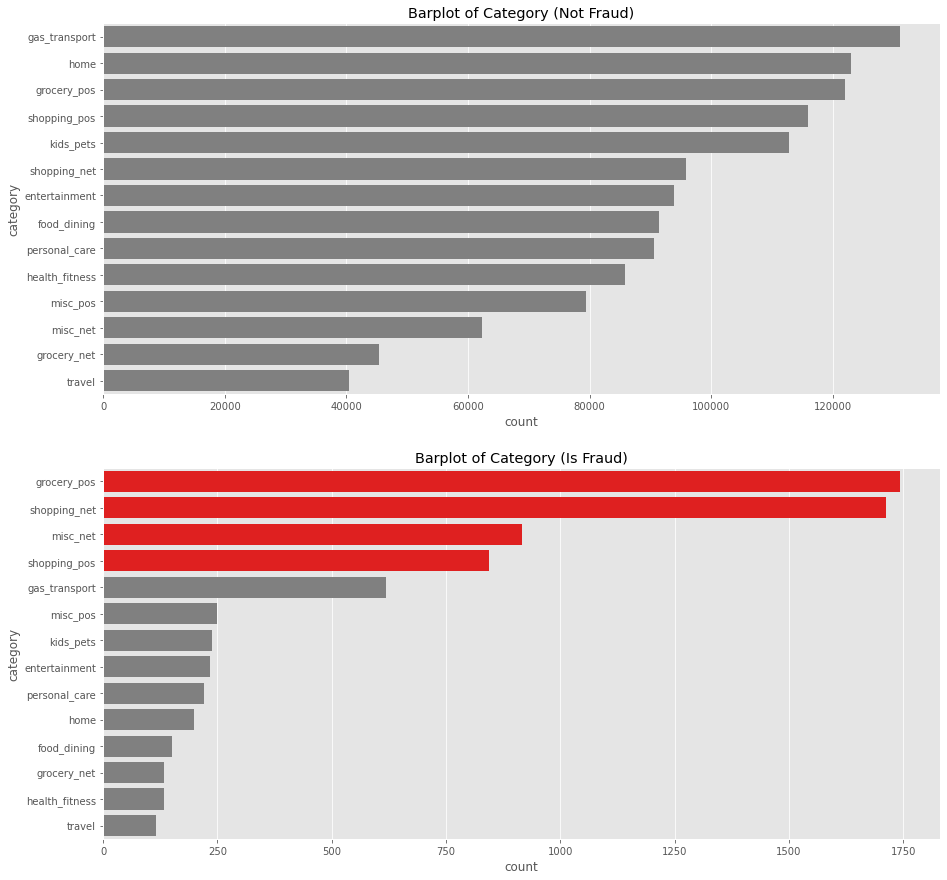

In [289]:
fig, ax = plt.subplots(2,1, figsize=(15,15))
sns.countplot(ax= ax[0],data= train_cleaned[train_cleaned['is_fraud']==0] , y='category', 
              orient='h', order=order_cat_not_fraud, color='gray')
ax[0].set_title('Barplot of Category (Not Fraud)')

sns.countplot(ax= ax[1],data= train_cleaned[train_cleaned['is_fraud']==1] , y='category', 
              orient='h', order=order_cat_is_fraud, palette = cat_palette)
ax[1].set_title('Barplot of Category (Is Fraud)');

In [290]:
train_cleaned.groupby(['is_fraud','category'])['amt'].mean().unstack().T.reset_index()

is_fraud,category,0,1
0,entertainment,63.118913,503.535579
1,food_dining,50.972816,120.076954
2,gas_transport,63.675782,12.288204
3,grocery_net,53.792817,12.162836
4,grocery_pos,114.172234,311.989616
5,health_fitness,54.234775,20.248421
6,home,57.949319,257.432626
7,kids_pets,57.620386,18.121674
8,misc_net,70.359176,797.012852
9,misc_pos,62.401757,218.284080


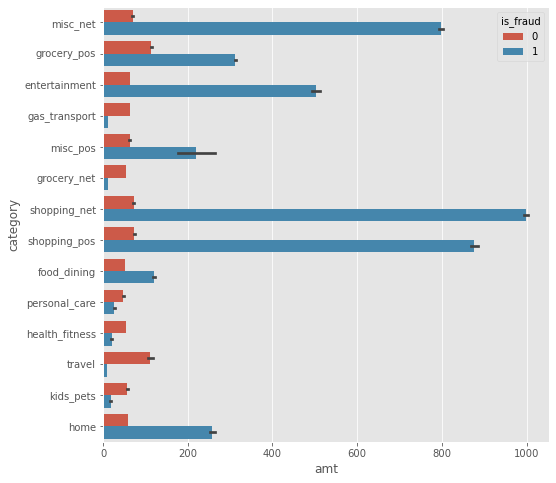

In [291]:
plt.figure(figsize=(8,8))
sns.barplot(y='category',x='amt', data=train_cleaned, hue='is_fraud');

In [292]:
train_cleaned[train_cleaned['is_fraud']==1]['category'].value_counts(normalize=True)

grocery_pos       0.232214
shopping_net      0.228217
misc_net          0.121902
shopping_pos      0.112310
gas_transport     0.082334
misc_pos          0.033307
kids_pets         0.031841
entertainment     0.031042
personal_care     0.029310
home              0.026379
food_dining       0.020117
grocery_net       0.017852
health_fitness    0.017719
travel            0.015454
Name: category, dtype: float64

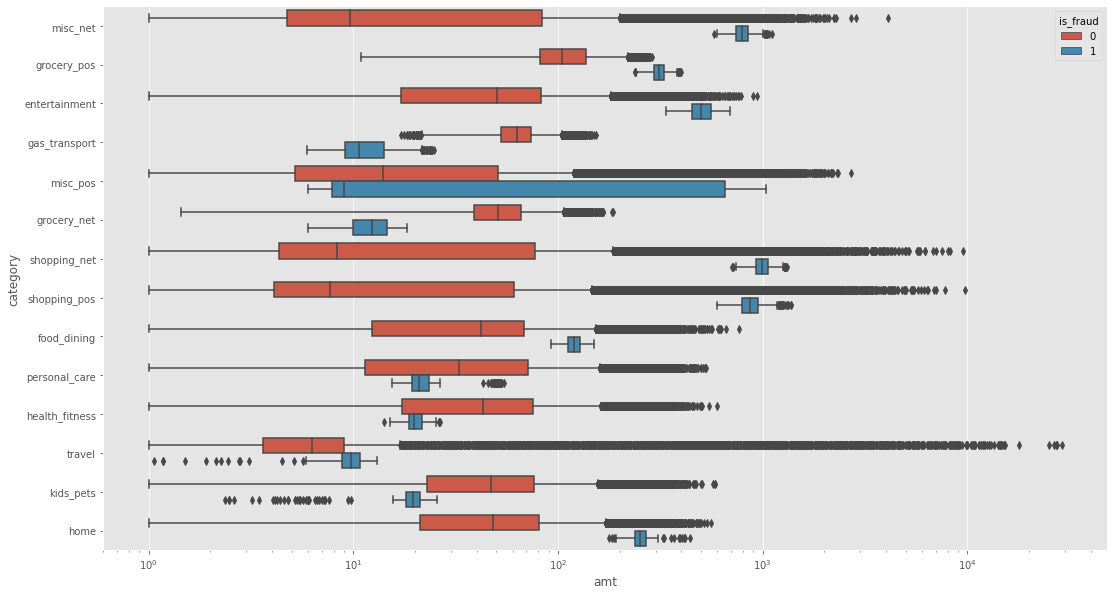

In [293]:
plt.figure(figsize=(18,10))
g= sns.boxplot(data=train_cleaned, x='amt', y='category', orient='h', hue='is_fraud')
g.set_xscale("log");

<AxesSubplot:xlabel='distance', ylabel='amt'>

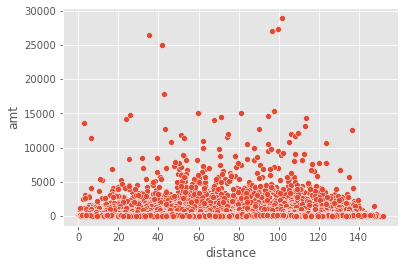

In [295]:
sns.scatterplot(data=train_cleaned, x='distance', y='amt')

In [296]:
train_cleaned['is_fraud'].unique()

array([0, 1], dtype=int64)

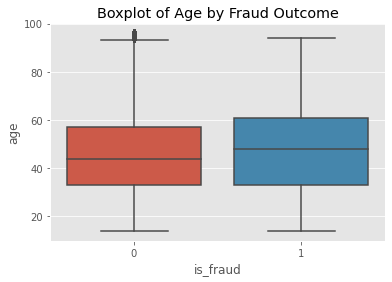

In [297]:
# plot boxplot on `age`
sns.boxplot(data=train_cleaned, x='is_fraud', y='age')
plt.title('Boxplot of Age by Fraud Outcome');

### Distance

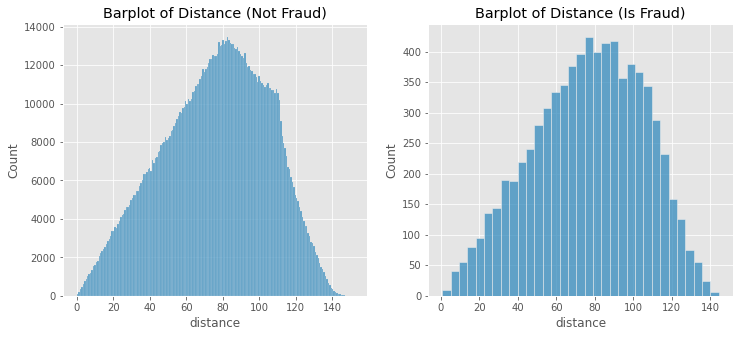

In [298]:
fig, ax = plt.subplots(1,2, figsize=(12,5))
sns.histplot(ax= ax[0],data= train_cleaned[train_cleaned['is_fraud']==0] , x='distance')
ax[0].set_title('Barplot of Distance (Not Fraud)')
sns.histplot(ax= ax[1],data= train_cleaned[train_cleaned['is_fraud']==1] , x='distance')
ax[1].set_title('Barplot of Distance (Is Fraud)');

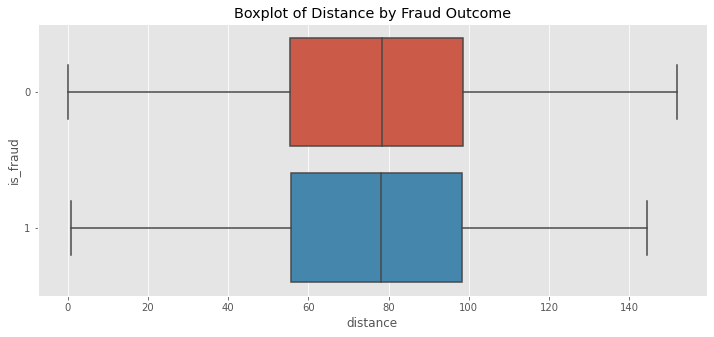

In [299]:
# plot boxplot on `age`
plt.figure(figsize=(12,5))
sns.boxplot(data=train_cleaned, y='is_fraud', x='distance', orient='h')
plt.title('Boxplot of Distance by Fraud Outcome');

In [300]:
print(skew(train_cleaned['distance']))

-0.23826879490463246


### EDA: Time

In [301]:
train_cleaned.columns

Index(['trans_datetime', 'cc_num', 'merchant', 'category', 'amt', 'gender',
       'street', 'city', 'state', 'zip', 'lat', 'long', 'city_pop', 'job',
       'trans_num', 'merch_lat', 'merch_long', 'is_fraud', 'name',
       'coords_ori', 'coords_merch', 'trans_year', 'trans_month', 'trans_week',
       'trans_day', 'trans_hour', 'trans_minute', 'trans_dayofweek', 'age',
       'distance', 'amt_group', 'age_group'],
      dtype='object')

In [302]:
train_cleaned.groupby(['trans_hour'])['is_fraud'].sum()

trans_hour
0      635
1      658
2      625
3      609
4       46
5       60
6       40
7       56
8       49
9       47
10      40
11      42
12      67
13      80
14      86
15      79
16      76
17      78
18      81
19      81
20      62
21      74
22    1931
23    1904
Name: is_fraud, dtype: int64

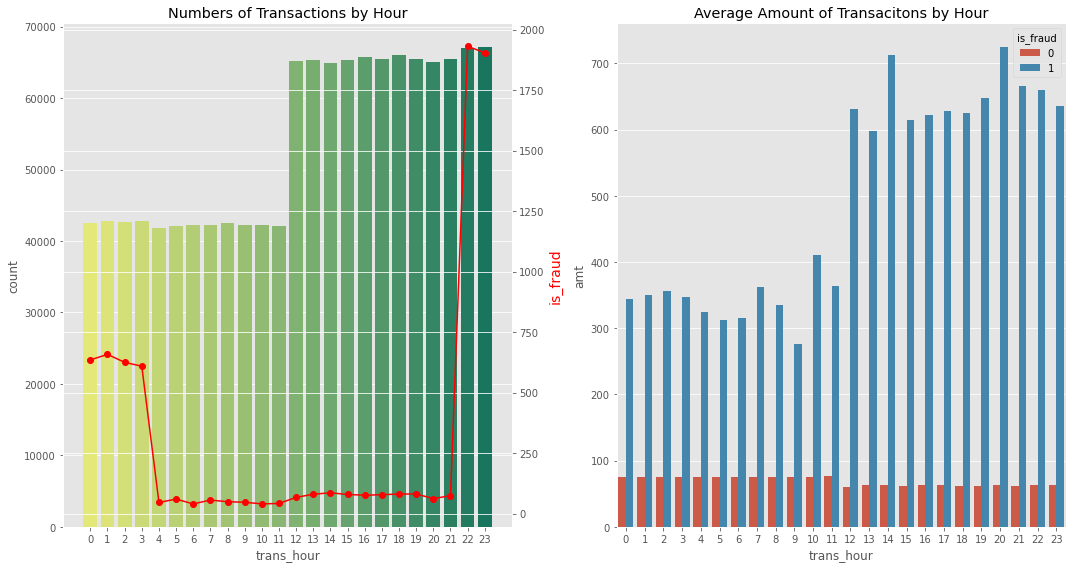

In [303]:
fig, ax = plt.subplots(1,2, figsize=(15,8))
sns.countplot(ax= ax[0],data= train_cleaned, x='trans_hour',palette='summer_r')
ax[0].set_title('Numbers of Transactions by Hour')
ax2 = ax[0].twinx()
ax2.plot(train_cleaned.groupby(['trans_hour'])['is_fraud'].sum(), marker='o', color='red')
ax2.set_ylabel("is_fraud",color="red",fontsize=14)

sns.barplot(ax= ax[1],data= train_cleaned , x='trans_hour', y='amt', hue='is_fraud',ci=None)
ax[1].set_title('Average Amount of Transacitons by Hour')
fig.tight_layout();

In [304]:
train_cleaned.groupby(['trans_dayofweek'])['is_fraud'].sum()

trans_dayofweek
0    1182
1     935
2     859
3    1008
4    1079
5    1227
6    1216
Name: is_fraud, dtype: int64

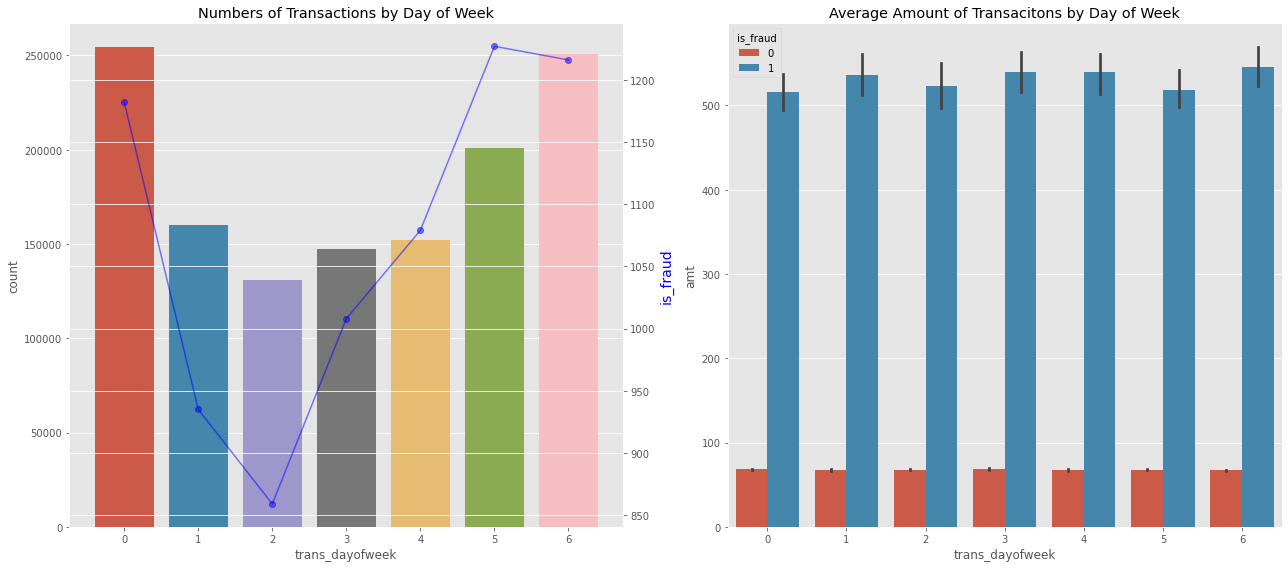

In [305]:
fig, ax = plt.subplots(1,2, figsize=(18,8))
sns.countplot(ax= ax[0],data= train_cleaned, x='trans_dayofweek')
ax[0].set_title('Numbers of Transactions by Day of Week')
ax2 = ax[0].twinx()
ax2.plot(train_cleaned.groupby(['trans_dayofweek'])['is_fraud'].sum(), marker='o', color='blue', alpha=0.5)
ax2.set_ylabel("is_fraud",color="blue",fontsize=14)

sns.barplot(ax= ax[1],data= train_cleaned , x='trans_dayofweek', y='amt', hue='is_fraud')
ax[1].set_title('Average Amount of Transacitons by Day of Week')
fig.tight_layout();

In [306]:
train_cleaned.groupby(['trans_month'])['is_fraud'].sum().reset_index()

,trans_month,is_fraud
0,1,849
1,2,853
2,3,938
3,4,678
4,5,935
5,6,688
6,7,331
7,8,382
8,9,418
9,10,454


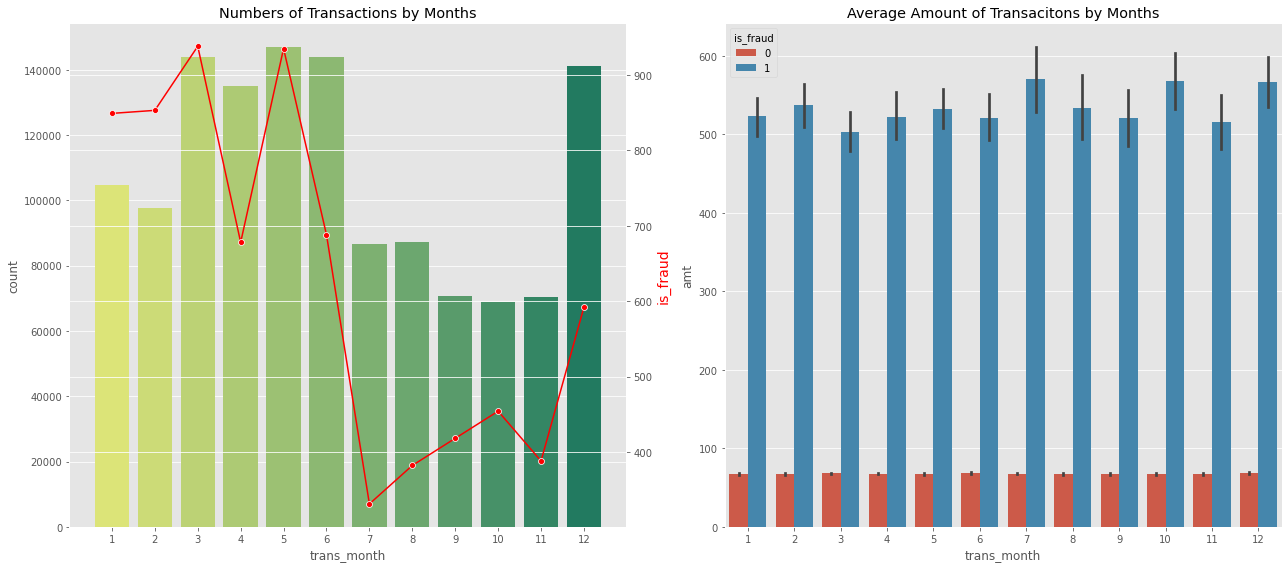

In [307]:
fig, ax = plt.subplots(1,2, figsize=(18,8))
sns.countplot(ax= ax[0],data= train_cleaned, x='trans_month', palette='summer_r')
ax[0].set_title('Numbers of Transactions by Months')
ax2 = ax[0].twinx()

temp = train_cleaned.groupby(['trans_month'])['is_fraud'].sum().reset_index()
sns.lineplot(x = temp.index,
             y = temp['is_fraud'], marker='o', color='red')
ax2.set_ylabel("is_fraud",color="red",fontsize=14)

sns.barplot(ax= ax[1],data= train_cleaned , x='trans_month', y='amt', hue='is_fraud')
ax[1].set_title('Average Amount of Transacitons by Months')
fig.tight_layout();

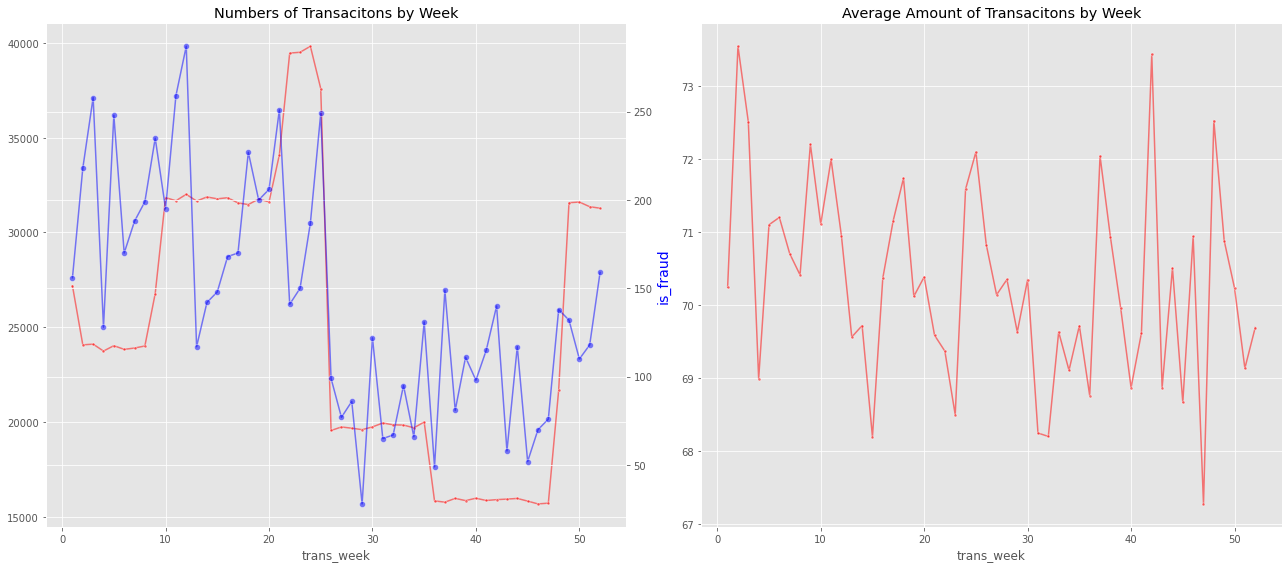

In [308]:
temp_week1 = train_cleaned.groupby(['trans_week'])['amt'].count()
temp_week2 = train_cleaned.groupby(['trans_week'])['is_fraud'].sum()
temp_week3 = train_cleaned.groupby(['trans_week'])['amt'].mean()

fig, ax = plt.subplots(1,2, figsize=(18,8))
sns.lineplot(ax=ax[0], x=temp_week1.index, y=temp_week1.values, marker='.', color='red', alpha=0.5)
ax[0].set_title('Numbers of Transacitons by Week')

ax2 = ax[0].twinx()
sns.lineplot(x=temp_week2.index, y=temp_week2.values, marker='o', color='blue', alpha=0.5)
ax2.set_ylabel("is_fraud",color="blue",fontsize=14)

sns.lineplot(ax=ax[1], x=temp_week3.index, y=temp_week3.values, marker='.', color='red', alpha=0.5);
ax[1].set_title('Average Amount of Transacitons by Week')
fig.tight_layout();

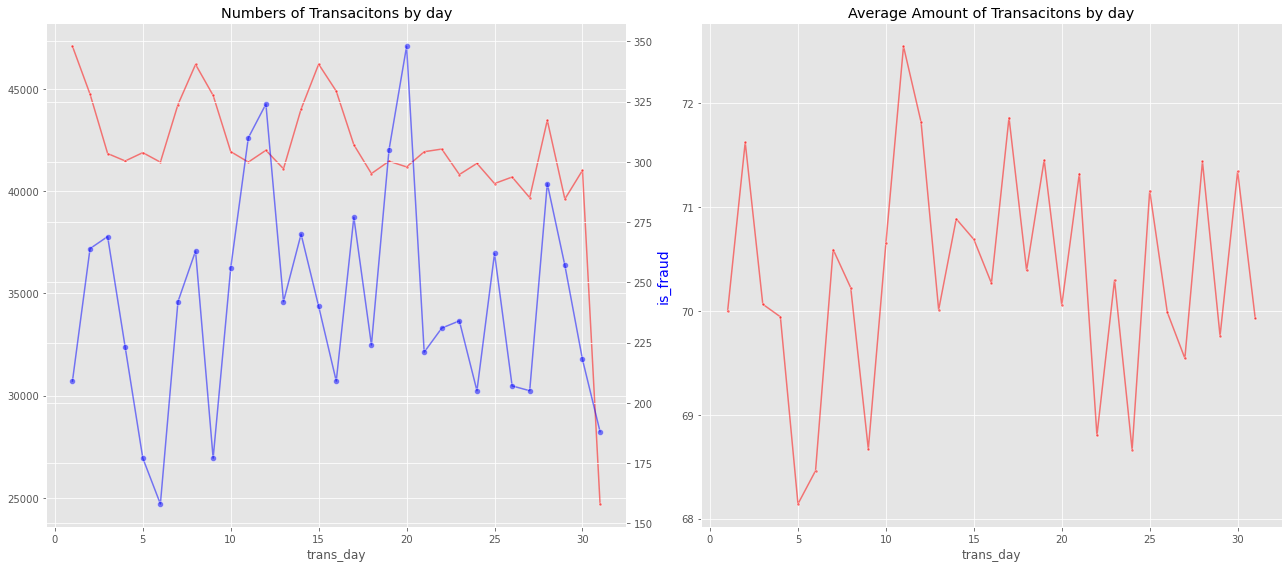

In [309]:
temp_day1 = train_cleaned.groupby(['trans_day'])['amt'].count()
temp_day2 = train_cleaned.groupby(['trans_day'])['is_fraud'].sum()
temp_day3 = train_cleaned.groupby(['trans_day'])['amt'].mean()

fig, ax = plt.subplots(1,2, figsize=(18,8))
sns.lineplot(ax=ax[0], x=temp_day1.index, y=temp_day1.values, marker='.', color='red', alpha=0.5)
ax[0].set_title('Numbers of Transacitons by day')

ax2 = ax[0].twinx()
sns.lineplot(x=temp_day2.index, y=temp_day2.values, marker='o', color='blue', alpha=0.5)
ax2.set_ylabel("is_fraud",color="blue",fontsize=14)

sns.lineplot(ax=ax[1], x=temp_day3.index, y=temp_day3.values, marker='.', color='red', alpha=0.5);
ax[1].set_title('Average Amount of Transacitons by day')
fig.tight_layout();

In [310]:
train_cleaned.groupby(['is_fraud','trans_year']).agg({'amt':['count','mean']})

amt            
                      count        mean
is_fraud trans_year                    
0        2019        919630   67.654524
         2020        369539   67.698430
1        2019          5220  530.234266
         2020          2286  533.799536

### State

In [311]:
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import plotly.graph_objects as go 
import plotly.express as px
import plotly as py

In [312]:
print(list(train_cleaned['state'].unique()))

['NC', 'WA', 'ID', 'MT', 'VA', 'PA', 'KS', 'TN', 'IA', 'WV', 'FL', 'CA', 'NM', 'NJ', 'OK', 'IN', 'MA', 'TX', 'WI', 'MI', 'WY', 'HI', 'NE', 'OR', 'LA', 'DC', 'KY', 'NY', 'MS', 'UT', 'AL', 'AR', 'MD', 'GA', 'ME', 'AZ', 'MN', 'OH', 'CO', 'VT', 'MO', 'SC', 'NV', 'IL', 'NH', 'SD', 'AK', 'ND', 'CT', 'RI', 'DE']


In [313]:
# create dictionary to be used by plotly
data = dict(type = 'choropleth',
            locations = train_cleaned.groupby('state')['city_pop'].mean().reset_index()['state'],
            locationmode = 'USA-states',
            colorscale = 'Turbo',
#             text = ['This is NC,', ' State of WA', ' ID', ' MT','VA','PA'],
            z = train_cleaned.groupby('state')['city_pop'].mean().reset_index()['city_pop'],
            colorbar = {'title':'city_pop'})

# create layout for plotly
layout = dict(title = 'CITY POPULATION', 
              geo={'scope':'usa'})

# plot chroropleth map
chromap = go.Figure(data = [data], layout=layout)
chromap.show()

In [544]:
state_fraud_rate = train_cleaned.groupby(['state']).agg({'is_fraud':['sum','mean']}).\
                    sort_values(('is_fraud','mean'), ascending=False).reset_index()

state_fraud_rate.head()

state is_fraud          
             sum      mean
0    DE        9  1.000000
1    RI       15  0.027273
2    AK       36  0.016981
3    NV       47  0.008382
4    CO      113  0.008141

In [543]:
# create dictionary to be used by plotly
data = dict(type = 'choropleth',
            locations = state_fraud_rate['state'],
            locationmode = 'USA-states',
            colorscale = 'Turbo',
#             text = ['This is NC,', ' State of WA', ' ID', ' MT','VA','PA'],
            z = state_fraud_rate[('is_fraud','mean')],
            colorbar = {'title':'fraud_rate'})

# create layout for plotly
layout = dict(title = 'Fraud Rate by States', 
              geo={'scope':'usa'})

# plot chroropleth map
chromap = go.Figure(data = [data], layout=layout)
chromap.show()

In [315]:
train_cleaned['state'].nunique()

51

In [316]:
train_cleaned['city'].nunique()

894

In [317]:
train_cleaned['zip'].nunique()

970

In [318]:
train_cleaned['coords_ori'].nunique()

970

In [319]:
train_cleaned.groupby(['city']).agg({'is_fraud':['sum','mean']}).sort_values(('is_fraud','mean'), ascending=False)

is_fraud     
                sum mean
city                    
Buellton          8  1.0
Winnsboro        11  1.0
Ashland          10  1.0
Clinton          12  1.0
Grenola           9  1.0
...             ...  ...
Manville          0  0.0
Malad_City        0  0.0
Luray             0  0.0
Lubbock           0  0.0
Zavalla           0  0.0

[894 rows x 2 columns]

In [320]:
train_cleaned[train_cleaned['is_fraud']==1].groupby('state').\
agg({'amt':['count','mean','median']}).sort_values(('amt','mean'), ascending=False)

amt                     
      count        mean   median
state                           
RI       15  732.984000  818.000
CT       16  674.275000  838.930
IN      142  633.890282  795.885
MA       69  633.533333  761.350
ID       11  626.721818  794.060
NH       59  619.903898  762.270
VT       72  617.669444  787.825
ND       57  596.441579  792.260
NM       82  569.868659  657.640
NJ      118  565.327373  694.460
HI        7  560.970000  796.910
NE      180  556.401722  634.605
TX      479  554.919436  580.360
WI      163  552.814356  537.370
MS      115  552.744000  673.330
ME      119  552.585882  671.930
KY      155  546.687806  523.270
MN      207  543.257923  574.190
TN      140  542.513143  482.130
OR      149  538.386980  584.940
LA       91  537.604945  712.350
FL      281  537.057046  371.980
PA      458  534.115000  468.330
NY      555  532.520072  390.850
GA      146  531.886027  351.925
NV       47  527.520851  731.550
SD       74  527.244595  357.605
OH      321  526.230467  357.620
CO      113  524.795841  338.030
CA      326  524.367853  359.560
MT       32  524.257500  336.945
AL      215  523.706930  349.660
WV      146  522.755616  457.505
OK      143  518.444965  374.570
IL      248  517.911250  449.035
AK       36  516.074167  362.505
DE        9  514.493333  296.250
VA      198  514.166566  346.255
MI      238  508.454118  337.645
AR      161  503.973975  351.400
MD      157  498.298599  333.780
KS      156  498.178846  324.175
SC      193  496.749741  347.460
AZ       37  495.503243  330.030
IA      142  492.993380  336.380
WY      110  491.854364  333.450
MO      191  487.393194  358.760
NC      149  486.111879  331.430
DC       21  459.017143  301.630
WA       96  456.171771  325.185
UT       61  413.518525  313.590

In [321]:
# create dictionary to be used by plotly
data = dict(type = 'choropleth',
            locations = train_cleaned.groupby('state')['amt'].sum().reset_index()['state'],
            locationmode = 'USA-states',
            colorscale = 'Turbo',
#             text = ['This is NC,', ' State of WA', ' ID', ' MT','VA','PA'],
            z = train_cleaned.groupby('state')['amt'].sum().reset_index()['amt'],
            colorbar = {'title':'amt'})

# create layout for plotly
layout = dict(title = 'Total Amount', 
              geo={'scope':'usa'})

# plot chroropleth map
chromap = go.Figure(data = [data], layout=layout)
chromap.show()

In [545]:
fraud_location = train_cleaned[train_cleaned['is_fraud']==1].groupby('state')['amt'].count().reset_index()['state']
fraud_count = train_cleaned[train_cleaned['is_fraud']==1].groupby('state')['amt'].count().reset_index()['amt']

non_fraud_location = train_cleaned[train_cleaned['is_fraud']==0].groupby('state')['amt'].count().reset_index()['state']
non_fraud_count = train_cleaned[train_cleaned['is_fraud']==0].groupby('state')['amt'].count().reset_index()['amt']

# create dictionary to be used by plotly
data = dict(type = 'choropleth',
            locations = non_fraud_location, #train_cleaned.groupby('state')['amt'].count().reset_index()['state'],
            locationmode = 'USA-states',
            colorscale = 'algae',
#             text = ['This is NC,', ' State of WA', ' ID', ' MT','VA','PA'],
            z = non_fraud_count, #train_cleaned.groupby('state')['amt'].mean().reset_index()['amt'],
            colorbar = {'title':'number of transactions'})

# create layout for plotly
layout = dict(title = 'NUMBER OF NON FRAUD TRANSACTIONS', 
              geo={'scope':'usa'})

# plot chroropleth map
chromap = go.Figure(data = [data], layout=layout)
chromap.show()

In [546]:
# create dictionary to be used by plotly
data = dict(type = 'choropleth',
            locations = fraud_location, #train_cleaned.groupby('state')['amt'].count().reset_index()['state'],
            locationmode = 'USA-states',
            colorscale = 'amp',
#             text = ['This is NC,', ' State of WA', ' ID', ' MT','VA','PA'],
            z = fraud_count, #train_cleaned.groupby('state')['amt'].mean().reset_index()['amt'],
            colorbar = {'title':'number of transactions'})

# create layout for plotly
layout = dict(title = 'NUMBER OF FRAUD TRANSACTIONS', 
              geo={'scope':'usa'})

# plot chroropleth map
chromap = go.Figure(data = [data], layout=layout)
chromap.show()

In [324]:
train_cleaned.groupby(['is_fraud','zip'])['amt'].count().sort_values()

is_fraud  zip  
1         36869       2
          75662       2
          70726       2
          33811       2
          28405       2
                   ... 
0         15484    3123
          82514    3506
          48088    3574
          34112    3595
          73754    3630
Name: amt, Length: 1651, dtype: int64

In [325]:
train_cleaned.columns

Index(['trans_datetime', 'cc_num', 'merchant', 'category', 'amt', 'gender',
       'street', 'city', 'state', 'zip', 'lat', 'long', 'city_pop', 'job',
       'trans_num', 'merch_lat', 'merch_long', 'is_fraud', 'name',
       'coords_ori', 'coords_merch', 'trans_year', 'trans_month', 'trans_week',
       'trans_day', 'trans_hour', 'trans_minute', 'trans_dayofweek', 'age',
       'distance', 'amt_group', 'age_group'],
      dtype='object')

In [326]:
train_cleaned['zip'].nunique(), train_cleaned['state'].nunique()

(970, 51)

## Feature Engineering

In [349]:
# display all the features
train_cleaned.columns

Index(['trans_datetime', 'cc_num', 'merchant', 'category', 'amt', 'gender',
       'street', 'city', 'state', 'zip', 'lat', 'long', 'city_pop', 'job',
       'trans_num', 'merch_lat', 'merch_long', 'is_fraud', 'name',
       'coords_ori', 'coords_merch', 'trans_year', 'trans_month', 'trans_week',
       'trans_day', 'trans_hour', 'trans_minute', 'trans_dayofweek', 'age',
       'distance', 'amt_group', 'age_group'],
      dtype='object')

In [350]:
print(f"Train_cleaned Shape before Feature Engineering: {train_cleaned.shape}")

Train_cleaned Shape before Feature Engineering: (1296675, 32)


__Create New Features:__
- Last transaction amount - `pre_amt`
- cummulative sum of transaction amount - `cum_sum`
- difference in transaction amount from last transaction - `amt_dff`
- average transaction amount - `amt_avg`
- last transaction datetime - `pre_trans_datetime`
- difference in transaction datetime from last transaction (minutes) - `diff_pre_trans_datetime`
- last transaction merchant coords - `pre_coords_merch`
- difference in distance from last transaction - `diff_distance`

In [351]:
# sort value by cc_num and follow by transaction datetime
train_cleaned = train_cleaned.sort_values(['cc_num','trans_datetime'])

pre_amt = []
cum_sum = []
amt_diff = []
pct_change = []
amt_avg = []
pre_trans_datetime = []
pre_coords_merch = []
diff_pre_trans_datetime = []

# loop through the data by different credit card number and create new feature
for cc in train_cleaned['cc_num'].unique():
    test_cc = train_cleaned[train_cleaned['cc_num'] == cc]
    fe_test_cc = test_cc[['trans_num','trans_datetime','amt','coords_merch']].copy()
    
    pre_amt.append(fe_test_cc['amt'].shift(1).values) #shift 1
    cum_sum.append(fe_test_cc['amt'].cumsum().values) #cumsum
    amt_diff.append(fe_test_cc['amt'].diff().values) #diff
    pct_change.append(fe_test_cc['amt'].pct_change().values) #percentage change in amt
    amt_avg.append(fe_test_cc['amt'].expanding(1).mean().values) #average of amount
    pre_trans_datetime.append(fe_test_cc['trans_datetime'].shift(1).values)
    pre_coords_merch.append(fe_test_cc['coords_merch'].shift(1).values)


# concatenate the variables into one array
pre_amt = np. concatenate(pre_amt, axis=0)
cum_sum = np.concatenate(cum_sum, axis=0)
amt_diff = np.concatenate(amt_diff, axis=0)
pct_change = np.concatenate(pct_change, axis=0)
amt_avg = np.concatenate(amt_avg, axis=0)
pre_trans_datetime = np.concatenate(pre_trans_datetime, axis=0)
pre_coords_merch = np.concatenate(pre_coords_merch, axis=0)


# create columns for the new feature
train_cleaned['pre_amt'] = pre_amt
train_cleaned['cum_sum'] = cum_sum
train_cleaned['amt_diff'] = amt_diff
train_cleaned['pct_change'] = pct_change
train_cleaned['amt_avg'] = amt_avg
train_cleaned['pre_trans_datetime'] = pre_trans_datetime
train_cleaned['pre_coords_merch'] = pre_coords_merch

In [352]:
# check null value
train_cleaned.isnull().sum()[train_cleaned.isnull().sum() >0]

pre_amt               983
amt_diff              983
pct_change            983
pre_trans_datetime    983
pre_coords_merch      983
dtype: int64

In [353]:
train_cleaned.head(2)

,trans_datetime,cc_num,merchant,category,amt,gender,street,city,state,zip,...,distance,amt_group,age_group,pre_amt,cum_sum,amt_diff,pct_change,amt_avg,pre_trans_datetime,pre_coords_merch
1017,2019-01-01 12:47:15,60416207185,"fraud_Jones,_Sawayn_and_Romaguera",misc_net,7.27,F,9886 Anita Drive,Fort_Washakie,WY,82514,...,127.629296,low,23_33,NaN,7.27,NaN,NaN,7.270,NaT,NaN
2724,2019-01-02 08:44:57,60416207185,fraud_Berge_LLC,gas_transport,52.94,F,9886 Anita Drive,Fort_Washakie,WY,82514,...,110.202992,above_medium,23_33,7.27,60.21,45.67,6.281981,30.105,2019-01-01 12:47:15,"(43.974711, -109.741904)"


### Difference in Datetime, Distance

In [354]:
# create new columns for differences in datetime from last transaction in minutes
train_cleaned['diff_minutes_pre_trans'] = (train_cleaned['trans_datetime'] - 
                                            train_cleaned['pre_trans_datetime']) / np.timedelta64(1,'m')

In [355]:
# create the function to calculate distance between coords
def calculate_distance(ori, merch):
    return distance.distance(ori, merch).km

print(f"Train_cleaned Shape before Feature Engineering: {train_cleaned.shape}")

# create a distance column
train_cleaned['diff_distance'] = train_cleaned.dropna().apply(lambda row: calculate_distance(row['coords_merch'], 
                                                                                               row['pre_coords_merch']), axis=1)

# drop the pre_trans_datetime
train_cleaned.drop(['pre_trans_datetime','pre_coords_merch'], axis=1, inplace=True)

print(f"Train_cleaned Shape after Feature Engineering: {train_cleaned.shape}")
train_cleaned.head(2)

Train_cleaned Shape before Feature Engineering: (1296675, 40)
Train_cleaned Shape after Feature Engineering: (1296675, 39)


,trans_datetime,cc_num,merchant,category,amt,gender,street,city,state,zip,...,distance,amt_group,age_group,pre_amt,cum_sum,amt_diff,pct_change,amt_avg,diff_minutes_pre_trans,diff_distance
1017,2019-01-01 12:47:15,60416207185,"fraud_Jones,_Sawayn_and_Romaguera",misc_net,7.27,F,9886 Anita Drive,Fort_Washakie,WY,82514,...,127.629296,low,23_33,NaN,7.27,NaN,NaN,7.270,NaN,NaN
2724,2019-01-02 08:44:57,60416207185,fraud_Berge_LLC,gas_transport,52.94,F,9886 Anita Drive,Fort_Washakie,WY,82514,...,110.202992,above_medium,23_33,7.27,60.21,45.67,6.281981,30.105,1197.7,224.614202


In [356]:
# verify and confirm the combination is valid
train_cleaned['diff_minutes_pre_trans'].min(), train_cleaned['diff_minutes_pre_trans'].max()

(0.0, 22357.85)

In [357]:
# verify and confirm the combination is valid
train_cleaned['diff_distance'].min(), train_cleaned['diff_distance'].max()

(0.08060349136264632, 285.60722549053435)

### Binarize - Gender

In [358]:
# convert Male(M) to 1 and Female(F) to 0
train_cleaned['gender'] = [1 if male =='M' else 0 for male in train_cleaned['gender'] ]
train_cleaned.rename(columns={'gender':'is_male'}, inplace=True)

In [359]:
# check the value counts of each category
train_cleaned['is_male'].value_counts()

0    709863
1    586812
Name: is_male, dtype: int64

In [360]:
train_cleaned.head(2)

,trans_datetime,cc_num,merchant,category,amt,is_male,street,city,state,zip,...,distance,amt_group,age_group,pre_amt,cum_sum,amt_diff,pct_change,amt_avg,diff_minutes_pre_trans,diff_distance
1017,2019-01-01 12:47:15,60416207185,"fraud_Jones,_Sawayn_and_Romaguera",misc_net,7.27,0,9886 Anita Drive,Fort_Washakie,WY,82514,...,127.629296,low,23_33,NaN,7.27,NaN,NaN,7.270,NaN,NaN
2724,2019-01-02 08:44:57,60416207185,fraud_Berge_LLC,gas_transport,52.94,0,9886 Anita Drive,Fort_Washakie,WY,82514,...,110.202992,above_medium,23_33,7.27,60.21,45.67,6.281981,30.105,1197.7,224.614202


### Spending Behavior: Numbers of Transaction *Last 1 hour, Last 24 Hours, Last 7 Days, Last 30 Days*

In [361]:
train_cleaned.shape

(1296675, 39)

In [362]:
time_list = ['1h','24h','7d','30d']

for t in time_list:
    df = train_cleaned.copy()
    df = df.groupby(['cc_num','trans_datetime'])['amt'].count().reset_index()
    df.index = df['trans_datetime']
    df = df.rename_axis(index={'trans_datetime':'datetime_index'})

    # create new feature rolling 1 hour for average transaction amount
    df = df.groupby(['cc_num'])['amt'].rolling(t, min_periods=1).sum().reset_index()
    df.columns = ['cc_num','trans_datetime',f'trans_last_{t}']

    # Merging all the rolling dataframe
    train_cleaned = pd.merge(train_cleaned, df, on=['cc_num','trans_datetime'])

In [363]:
train_cleaned.shape

(1296675, 43)

### Spending Behavior: Average Transaction Amount *Last 1 Hour, Last 24 Hour, Last 7 Days, Last 30 Days*

In [364]:
time_list = ['1h','24h','7d','30d']

for t in time_list:
    df = train_cleaned.copy()
    df = df.groupby(['cc_num','trans_datetime'])['amt'].mean().reset_index()
    df.index = df['trans_datetime']
    df = df.rename_axis(index={'trans_datetime':'datetime_index'})

    # create new feature rolling 1 hour for average transaction amount
    df = df.groupby(['cc_num'])['amt'].rolling(t).mean().reset_index()
    df.columns = ['cc_num','trans_datetime',f'avg_last_{t}']

    # Merging all the rolling dataframe
    train_cleaned = pd.merge(train_cleaned, df, on=['cc_num','trans_datetime'])

In [365]:
train_cleaned.shape

(1296675, 47)

### Spending Behavior: Min & Max Transaction Amount *Last 1 Hour, Last 24 Hour, Last 7 Days, Last 30 Days*

In [366]:
time_list = ['1h','24h','7d','30d']

for t in time_list:
    df = train_cleaned.copy()
    df = df.groupby(['cc_num','trans_datetime'])['amt'].min().reset_index()
    df.index = df['trans_datetime']
    df = df.rename_axis(index={'trans_datetime':'datetime_index'})

    # create new feature rolling 1 hour for average transaction amount
    df = df.groupby(['cc_num'])['amt'].rolling(t).min().reset_index()
    df.columns = ['cc_num','trans_datetime',f'min_last_{t}']

    # Merging all the rolling dataframe
    train_cleaned = pd.merge(train_cleaned, df, on=['cc_num','trans_datetime'])

In [367]:
time_list = ['1h','24h','7d','30d']

for t in time_list:
    df = train_cleaned.copy()
    df = df.groupby(['cc_num','trans_datetime'])['amt'].max().reset_index()
    df.index = df['trans_datetime']
    df = df.rename_axis(index={'trans_datetime':'datetime_index'})

    # create new feature rolling 1 hour for average transaction amount
    df = df.groupby(['cc_num'])['amt'].rolling(t).max().reset_index()
    df.columns = ['cc_num','trans_datetime',f'max_last_{t}']

    # Merging all the rolling dataframe
    train_cleaned = pd.merge(train_cleaned, df, on=['cc_num','trans_datetime'])

### Merchant Behavior: Numbers of Transaction *Last 24 hour, Last 7 Days, Last 14 days, Last 30 Days*

In [373]:
time_list = ['24h','7d', '14d', '30d']

for t in time_list:
    df = train_cleaned.copy()
    df = df.groupby(['merchant','trans_datetime'])['amt'].count().reset_index()
    df.index = df['trans_datetime']
    df = df.rename_axis(index={'trans_datetime':'datetime_index'})

    # create new feature rolling 1 hour for average transaction amount
    df = df.groupby(['merchant'])['amt'].rolling(t, min_periods=1).sum().reset_index()
    df.columns = ['merchant','trans_datetime',f'merch_last_{t}']

    # Merging all the rolling dataframe
    train_cleaned = pd.merge(train_cleaned, df, on=['merchant','trans_datetime'])

### Merchant Behavior: Average Transaction Amount *Last 24 hour, Last 7 Days, Last 14 days, Last 30 Days*

In [380]:
time_list = ['24h','7d', '14d', '30d']

for t in time_list:
    df = train_cleaned.copy()
    df = df.groupby(['merchant','trans_datetime'])['amt'].mean().reset_index()
    df.index = df['trans_datetime']
    df = df.rename_axis(index={'trans_datetime':'datetime_index'})

    # create new feature rolling 1 hour for average transaction amount
    df = df.groupby(['merchant'])['amt'].rolling(t).mean().reset_index()
    df.columns = ['merchant','trans_datetime',f'avg_merch_last_{t}']

    # Merging all the rolling dataframe
    train_cleaned = pd.merge(train_cleaned, df, on=['merchant','trans_datetime'])

### Merchant Behavior: Min & Max Transaction Amount *Last 24 hour, Last 7 Days, Last 14 days, Last 30 Days*

In [381]:
time_list = ['24h','7d', '14d', '30d']

for t in time_list:
    df = train_cleaned.copy()
    df = df.groupby(['merchant','trans_datetime'])['amt'].min().reset_index()
    df.index = df['trans_datetime']
    df = df.rename_axis(index={'trans_datetime':'datetime_index'})

    # create new feature rolling 1 hour for average transaction amount
    df = df.groupby(['merchant'])['amt'].rolling(t).min().reset_index()
    df.columns = ['merchant','trans_datetime',f'min_merch_last_{t}']

    # Merging all the rolling dataframe
    train_cleaned = pd.merge(train_cleaned, df, on=['merchant','trans_datetime'])

In [382]:
time_list = ['24h','7d', '14d', '30d']

for t in time_list:
    df = train_cleaned.copy()
    df = df.groupby(['merchant','trans_datetime'])['amt'].max().reset_index()
    df.index = df['trans_datetime']
    df = df.rename_axis(index={'trans_datetime':'datetime_index'})

    # create new feature rolling 1 hour for average transaction amount
    df = df.groupby(['merchant'])['amt'].rolling(t).max().reset_index()
    df.columns = ['merchant','trans_datetime',f'max_merch_last_{t}']

    # Merging all the rolling dataframe
    train_cleaned = pd.merge(train_cleaned, df, on=['merchant','trans_datetime'])

In [383]:
print(train_cleaned.shape)
train_cleaned.head()

(1296675, 71)


,trans_datetime,cc_num,merchant,category,amt,is_male,street,city,state,zip,...,avg_merch_last_14d,avg_merch_last_30d,min_merch_last_24h,min_merch_last_7d,min_merch_last_14d,min_merch_last_30d,max_merch_last_24h,max_merch_last_7d,max_merch_last_14d,max_merch_last_30d
0,2019-01-01 12:47:15,60416207185,"fraud_Jones,_Sawayn_and_Romaguera",misc_net,7.27,0,9886 Anita Drive,Fort_Washakie,WY,82514,...,7.270000,7.270000,7.27,7.27,7.27,7.27,7.27,7.27,7.27,7.27
1,2019-01-02 08:44:57,60416207185,fraud_Berge_LLC,gas_transport,52.94,0,9886 Anita Drive,Fort_Washakie,WY,82514,...,67.300000,67.300000,52.94,52.94,52.94,52.94,79.01,79.39,79.39,79.39
2,2019-01-02 08:47:36,60416207185,fraud_Luettgen_PLC,gas_transport,82.08,0,9886 Anita Drive,Fort_Washakie,WY,82514,...,66.778000,66.778000,57.35,47.10,47.10,47.10,82.08,82.08,82.08,82.08
3,2019-01-02 12:38:14,60416207185,fraud_Daugherty_LLC,kids_pets,34.79,0,9886 Anita Drive,Fort_Washakie,WY,82514,...,54.058333,54.058333,26.85,26.85,26.85,26.85,99.84,99.84,99.84,99.84
4,2019-01-02 13:10:46,60416207185,fraud_Beier_and_Sons,home,27.18,0,9886 Anita Drive,Fort_Washakie,WY,82514,...,58.375000,58.375000,24.46,24.46,24.46,24.46,173.49,173.49,173.49,173.49


### Internet Transactions

In [399]:
# categorize internet transaction as 1, else 0
train_cleaned['internet_transaction'] = [1 if x == True else 0 for x in train_cleaned['category'].str.contains('net')]

In [402]:
# check total numbers of na due to feature engineering
train_cleaned.isnull().sum()[train_cleaned.isnull().sum() > 0]

pre_amt                   983
amt_diff                  983
pct_change                983
diff_minutes_pre_trans    983
diff_distance             983
dtype: int64

In [405]:
# replace all na values
train_cleaned = train_cleaned.replace(np.nan, 0)

# check null value
train_cleaned.isnull().sum()[train_cleaned.isnull().sum() > 0]

Series([], dtype: int64)

In [406]:
# check correlation against target
train_cleaned.corr()['is_fraud'].sort_values(ascending=False)

is_fraud                  1.000000
avg_last_24h              0.313742
avg_last_7d               0.280201
max_last_1h               0.238606
avg_last_1h               0.230499
amt                       0.219404
avg_last_30d              0.215524
min_last_1h               0.194339
pre_amt                   0.192678
amt_avg                   0.192004
max_last_24h              0.163575
min_last_24h              0.128948
avg_merch_last_24h        0.113606
max_merch_last_24h        0.103727
min_last_30d              0.086359
trans_last_1h             0.080746
min_last_7d               0.075436
max_last_7d               0.058968
avg_merch_last_7d         0.057553
avg_merch_last_14d        0.053518
avg_merch_last_30d        0.052855
min_merch_last_24h        0.044168
internet_transaction      0.043578
max_merch_last_7d         0.038901
max_merch_last_14d        0.027590
max_merch_last_30d        0.019987
pct_change                0.018532
amt_diff                  0.018340
min_merch_last_30d  

## RFM Analysis

In [423]:
train_cleaned_rfm = train_cleaned.groupby(['cc_num']).agg(first_trans = ('trans_datetime','min'),\
                                                          last_trans = ('trans_datetime','max'),\
                                                          frequency = ('trans_datetime','count'),
                                                          amt_sum = ('amt','sum')).reset_index()

train_cleaned_rfm.head()

,cc_num,first_trans,last_trans,frequency,amt_sum
0,60416207185,2019-01-01 12:47:15,2020-06-21 08:54:21,1518,85043.47
1,60422928733,2019-01-03 18:38:26,2020-06-21 09:19:28,1531,105640.20
2,60423098130,2019-01-01 06:48:36,2020-06-19 01:14:31,510,58673.63
3,60427851591,2019-01-01 07:36:27,2020-06-19 13:06:04,528,59129.61
4,60487002085,2019-01-06 03:23:55,2020-06-20 15:44:36,496,25160.11


In [427]:
recent_date = train_cleaned_rfm['last_trans'].max()
train_cleaned_rfm['recency'] = train_cleaned_rfm['last_trans'].apply(lambda x: (recent_date - x)/ np.timedelta64(1,'D'))

train_cleaned_rfm.head()

,cc_num,first_trans,last_trans,frequency,amt_sum,recency
0,60416207185,2019-01-01 12:47:15,2020-06-21 08:54:21,1518,85043.47,0.138380
1,60422928733,2019-01-03 18:38:26,2020-06-21 09:19:28,1531,105640.20,0.120938
2,60423098130,2019-01-01 06:48:36,2020-06-19 01:14:31,510,58673.63,2.457708
3,60427851591,2019-01-01 07:36:27,2020-06-19 13:06:04,528,59129.61,1.963576
4,60487002085,2019-01-06 03:23:55,2020-06-20 15:44:36,496,25160.11,0.853484


In [437]:
train_cleaned_rfm['recency'].describe()

count    983.000000
mean      21.494355
std       87.131266
min        0.000000
25%        0.115347
50%        0.288623
75%        0.692830
max      534.520081
Name: recency, dtype: float64

In [443]:
train_cleaned_rfm['recency_score'] = pd.qcut(train_cleaned_rfm['recency'], 
                                             [0, 0.1, 0.25, 0.5, 0.75, 0.9, 1], labels=[6, 5, 4, 3, 2, 1]).astype(int)

train_cleaned_rfm.head()

,cc_num,first_trans,last_trans,frequency,amt_sum,recency,recency_score
0,60416207185,2019-01-01 12:47:15,2020-06-21 08:54:21,1518,85043.47,0.138380,4
1,60422928733,2019-01-03 18:38:26,2020-06-21 09:19:28,1531,105640.20,0.120938,4
2,60423098130,2019-01-01 06:48:36,2020-06-19 01:14:31,510,58673.63,2.457708,1
3,60427851591,2019-01-01 07:36:27,2020-06-19 13:06:04,528,59129.61,1.963576,2
4,60487002085,2019-01-06 03:23:55,2020-06-20 15:44:36,496,25160.11,0.853484,2


In [444]:
train_cleaned_rfm['frequency'].describe()

count     983.000000
mean     1319.099695
std       812.235900
min         7.000000
25%       525.000000
50%      1054.000000
75%      2025.000000
max      3123.000000
Name: frequency, dtype: float64

In [445]:
train_cleaned_rfm['frequency_score'] = pd.qcut(train_cleaned_rfm['frequency'], [0, 0.25, 0.5, 0.75, 1],\
                                             labels=[1, 2, 3, 4]).astype("int")

train_cleaned_rfm.head()

,cc_num,first_trans,last_trans,frequency,amt_sum,recency,recency_score,frequency_score
0,60416207185,2019-01-01 12:47:15,2020-06-21 08:54:21,1518,85043.47,0.138380,4,3
1,60422928733,2019-01-03 18:38:26,2020-06-21 09:19:28,1531,105640.20,0.120938,4,3
2,60423098130,2019-01-01 06:48:36,2020-06-19 01:14:31,510,58673.63,2.457708,1,1
3,60427851591,2019-01-01 07:36:27,2020-06-19 13:06:04,528,59129.61,1.963576,2,2
4,60487002085,2019-01-06 03:23:55,2020-06-20 15:44:36,496,25160.11,0.853484,2,1


In [446]:
train_cleaned_rfm['amt_sum'].describe()

count       983.000000
mean      92800.029400
std       59584.778847
min        1348.530000
25%       43554.990000
50%       88514.240000
75%      126784.210000
max      296436.730000
Name: amt_sum, dtype: float64

In [447]:
train_cleaned_rfm['amt_score'] = pd.qcut(train_cleaned_rfm['amt_sum'], [0, 0.25, 0.5, 0.75, 1],\
                                             labels=[1, 2, 3, 4]).astype("int")

train_cleaned_rfm.head()

,cc_num,first_trans,last_trans,frequency,amt_sum,recency,recency_score,frequency_score,amt_score
0,60416207185,2019-01-01 12:47:15,2020-06-21 08:54:21,1518,85043.47,0.138380,4,3,2
1,60422928733,2019-01-03 18:38:26,2020-06-21 09:19:28,1531,105640.20,0.120938,4,3,3
2,60423098130,2019-01-01 06:48:36,2020-06-19 01:14:31,510,58673.63,2.457708,1,1,2
3,60427851591,2019-01-01 07:36:27,2020-06-19 13:06:04,528,59129.61,1.963576,2,2,2
4,60487002085,2019-01-06 03:23:55,2020-06-20 15:44:36,496,25160.11,0.853484,2,1,1


In [448]:
train_cleaned_rfm['R_rank'] = train_cleaned_rfm['recency'].rank(ascending=False)
train_cleaned_rfm['F_rank'] = train_cleaned_rfm['frequency'].rank(ascending=True)
train_cleaned_rfm['M_rank'] = train_cleaned_rfm['amt_sum'].rank(ascending=True)
 
# normalizing the rank of the customers
train_cleaned_rfm['R_rank_norm'] = (train_cleaned_rfm['R_rank']/train_cleaned_rfm['R_rank'].max())*100
train_cleaned_rfm['F_rank_norm'] = (train_cleaned_rfm['F_rank']/train_cleaned_rfm['F_rank'].max())*100
train_cleaned_rfm['M_rank_norm'] = (train_cleaned_rfm['F_rank']/train_cleaned_rfm['M_rank'].max())*100
 
train_cleaned_rfm.drop(columns=['R_rank', 'F_rank', 'M_rank'], inplace=True)
 
train_cleaned_rfm.head()

,cc_num,first_trans,last_trans,frequency,amt_sum,recency,recency_score,frequency_score,amt_score,R_rank_norm,F_rank_norm,M_rank_norm
0,60416207185,2019-01-01 12:47:15,2020-06-21 08:54:21,1518,85043.47,0.138380,4,3,2,70.498474,54.809160,54.781282
1,60422928733,2019-01-03 18:38:26,2020-06-21 09:19:28,1531,105640.20,0.120938,4,3,3,73.855544,59.541985,59.511699
2,60423098130,2019-01-01 06:48:36,2020-06-19 01:14:31,510,58673.63,2.457708,1,1,2,9.359105,16.030534,16.022380
3,60427851591,2019-01-01 07:36:27,2020-06-19 13:06:04,528,59129.61,1.963576,2,2,2,10.579858,26.106870,26.093591
4,60487002085,2019-01-06 03:23:55,2020-06-20 15:44:36,496,25160.11,0.853484,2,1,1,21.057986,9.872774,9.867752


In [449]:
train_cleaned_rfm['rfm_score'] = (train_cleaned_rfm['R_rank_norm'] + train_cleaned_rfm['F_rank_norm'] + \
train_cleaned_rfm['M_rank_norm']) / 300 *5

In [451]:
train_cleaned_rfm.sort_values('rfm_score', ascending=False).head()

,cc_num,first_trans,last_trans,frequency,amt_sum,recency,recency_score,frequency_score,amt_score,R_rank_norm,F_rank_norm,M_rank_norm,rfm_score
272,213112402583773,2019-01-01 01:08:31,2020-06-21 12:07:53,3117,179368.37,0.003981,6,4,4,98.474059,99.745547,99.694812,4.965240
869,6534628260579800,2019-01-01 01:01:48,2020-06-21 12:03:37,3112,163214.11,0.006944,6,4,4,97.660224,99.541985,99.491353,4.944893
772,4904681492230012,2019-01-01 11:26:19,2020-06-21 12:06:12,3095,178563.56,0.005150,6,4,4,97.965412,98.931298,98.880977,4.929628
43,630424987505,2019-01-01 08:42:04,2020-06-21 11:52:42,3099,179584.45,0.014525,6,4,4,95.422177,99.033079,98.982706,4.890633
281,213141712584544,2019-01-01 00:27:45,2020-06-21 12:11:23,3046,271661.15,0.001551,6,4,4,99.389624,96.895674,96.846389,4.885528


In [452]:
train_cleaned_rfm['rfm_score'].describe()

count    983.000000
mean       2.502968
std        1.278353
min        0.020351
25%        1.524415
50%        2.604867
75%        3.540839
max        4.965240
Name: rfm_score, dtype: float64

In [490]:

train_cleaned_rfm["customer_segment"] = np.where(train_cleaned_rfm['rfm_score'] > 4.5, "Top_Cust",
                                                 (np.where(train_cleaned_rfm['rfm_score'] > 4, "High_value_Cust",
                                                           (np.where(train_cleaned_rfm['rfm_score'] > 3, "Medium_Value_Cust",
                                                                     np.where(train_cleaned_rfm['rfm_score'] > 1.6, 
                            'Low_Value_Cust', 'Lost_Cust'))))))

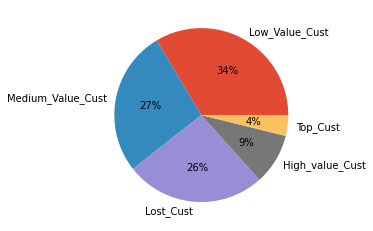

In [491]:
plt.pie(train_cleaned_rfm['customer_segment'].value_counts(),
        labels=train_cleaned_rfm['customer_segment'].value_counts().index,
        autopct='%.0f%%')
plt.show()

In [492]:
train_cleaned_rfm.groupby(['customer_segment']).agg({'frequency':['count','mean', 'min','max'], 
                                                     'amt_sum':['mean','median','min','max'],
                                                     'recency':['mean','median','min','max']}).\
round(3).sort_values(('amt_sum','mean'), ascending=False)

frequency                           amt_sum              \
                      count      mean   min   max        mean      median   
customer_segment                                                            
Top_Cust                 38  2880.974  2523  3123  203417.086  181537.335   
High_value_Cust          93  2413.086  1959  3101  169829.946  156000.510   
Medium_Value_Cust       266  1885.910  1045  3123  130067.634  123244.815   
Low_Value_Cust          330  1089.839   493  2035   76395.084   70678.565   
Lost_Cust               256   396.414     7  1026   30820.415   33739.285   

                                        recency                         
                         min        max    mean median    min      max  
customer_segment                                                        
Top_Cust           124081.92  296436.73   0.041  0.028  0.002    0.125  
High_value_Cust    112757.89  290478.49   0.101  0.082  0.000    0.359  
Medium_Value_Cust   63416.41  270698.48   0.232  0.179  0.000    0.838  
Low_Value_Cust      22403.39  169340.86   0.389  0.274  0.001    2.644  
Lost_Cust            1348.53   97906.83  81.749  1.541  0.173  534.520

In [493]:
train_cleaned_rfm.head(2)

,cc_num,first_trans,last_trans,frequency,amt_sum,recency,recency_score,frequency_score,amt_score,R_rank_norm,F_rank_norm,M_rank_norm,rfm_score,customer_segment
0,60416207185,2019-01-01 12:47:15,2020-06-21 08:54:21,1518,85043.47,0.138380,4,3,2,70.498474,54.809160,54.781282,3.001482,Medium_Value_Cust
1,60422928733,2019-01-03 18:38:26,2020-06-21 09:19:28,1531,105640.20,0.120938,4,3,3,73.855544,59.541985,59.511699,3.215154,Medium_Value_Cust


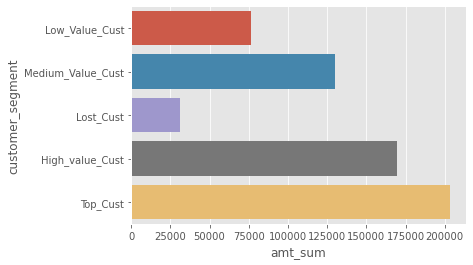

In [494]:
sns.barplot(data=train_cleaned_rfm.groupby('customer_segment').mean()['amt_sum'].to_frame().reset_index(),
            x='amt_sum', y='customer_segment', order =train_cleaned_rfm['customer_segment'].value_counts().index);

In [496]:
# Merge the customer_segment back to train_cleaned as new Feature
train_cleaned = pd.merge(train_cleaned, train_cleaned_rfm[['cc_num','customer_segment']], on=['cc_num'])

In [497]:
train_cleaned.head()

,trans_datetime,cc_num,merchant,category,amt,is_male,street,city,state,zip,...,min_merch_last_24h,min_merch_last_7d,min_merch_last_14d,min_merch_last_30d,max_merch_last_24h,max_merch_last_7d,max_merch_last_14d,max_merch_last_30d,internet_transaction,customer_segment
0,2019-01-01 12:47:15,60416207185,"fraud_Jones,_Sawayn_and_Romaguera",misc_net,7.27,0,9886 Anita Drive,Fort_Washakie,WY,82514,...,7.27,7.27,7.27,7.27,7.27,7.27,7.27,7.27,1,Medium_Value_Cust
1,2019-01-02 08:44:57,60416207185,fraud_Berge_LLC,gas_transport,52.94,0,9886 Anita Drive,Fort_Washakie,WY,82514,...,52.94,52.94,52.94,52.94,79.01,79.39,79.39,79.39,0,Medium_Value_Cust
2,2019-01-02 08:47:36,60416207185,fraud_Luettgen_PLC,gas_transport,82.08,0,9886 Anita Drive,Fort_Washakie,WY,82514,...,57.35,47.10,47.10,47.10,82.08,82.08,82.08,82.08,0,Medium_Value_Cust
3,2019-01-02 12:38:14,60416207185,fraud_Daugherty_LLC,kids_pets,34.79,0,9886 Anita Drive,Fort_Washakie,WY,82514,...,26.85,26.85,26.85,26.85,99.84,99.84,99.84,99.84,0,Medium_Value_Cust
4,2019-01-02 13:10:46,60416207185,fraud_Beier_and_Sons,home,27.18,0,9886 Anita Drive,Fort_Washakie,WY,82514,...,24.46,24.46,24.46,24.46,173.49,173.49,173.49,173.49,0,Medium_Value_Cust


### Clustering

In [498]:
# Clustering
from sklearn.cluster import KMeans, DBSCAN
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import silhouette_score
from sklearn.neighbors import KNeighborsClassifier

In [499]:
def scale_minmax(X):
    mm = MinMaxScaler()
    return mm.fit_transform(X)

In [512]:
# plot dd scatter plot
def plot_cluster_3d(df, cl, x, y, z):
    temp_df = df.copy()
    X = temp_df[['long','lat','amt']]
    X_sc = scale_minmax(X)
    cl.fit(X_sc)
    df['cluster'] = cl.labels_
    sil = silhouette_score(X_sc, cl.labels_)
    print(f"SILHOUETTE SCORE = {sil}")
    
    fig = plt.figure(figsize = (20, 16))
    ax = plt.axes(projection = '3d')
    ax.scatter3D(df[x], df[y], df[z], c=df['cluster'], cmap = 'tab20')
    ax.set_xlabel('longitude', fontsize=15)
    ax.set_ylabel('latitude', fontsize=15)
    ax.set_zlabel('amount', fontsize=15)
    ax.set_title(f'3D Scatter Plot for Trap Location and Number of Mosquitos with DBSCAN', fontsize=20)
    return plt.show()

In [513]:
train_cleaned['merchant'].nunique()

693

In [514]:
train_cleaned['coords_ori'].nunique()

970

In [515]:
location_grp = train_cleaned.groupby(['lat','long']).agg({'amt':'mean','is_fraud':'mean'}).reset_index() 

In [516]:
location_grp['is_fraud'] = [1 if x > 0 else x for x in location_grp2['is_fraud'] ]
location_grp['is_fraud'].value_counts()

1.0    754
0.0    216
Name: is_fraud, dtype: int64

In [506]:
# location_grp = train_cleaned.groupby(['lat','long']).mean()['amt'].reset_index()
# location_grp.head()

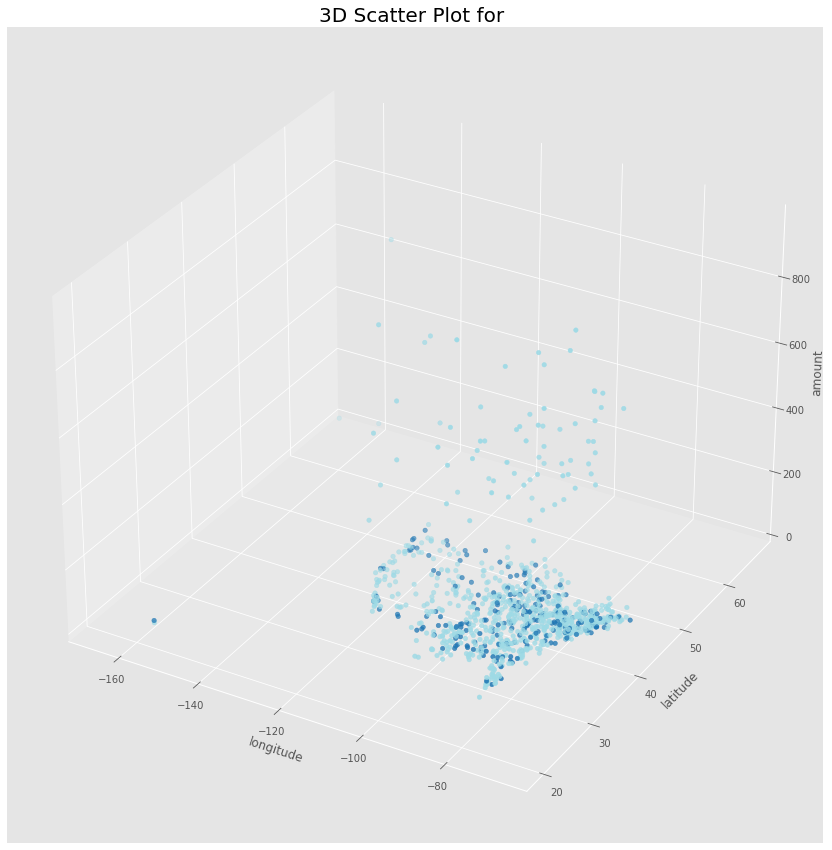

In [517]:
# scatter plot in 3D
fig = plt.figure(figsize = (18, 15))
ax = plt.axes(projection = '3d')
ax.scatter3D(location_grp['long'], location_grp['lat'], location_grp['amt'], 
             c=location_grp['is_fraud'], cmap = 'tab20')
ax.set_xlabel('longitude')
ax.set_ylabel('latitude')
ax.set_zlabel('amount')
ax.set_title('3D Scatter Plot for ', fontsize=20);

In [518]:
%matplotlib inline

SILHOUETTE SCORE = -0.2206435297621701


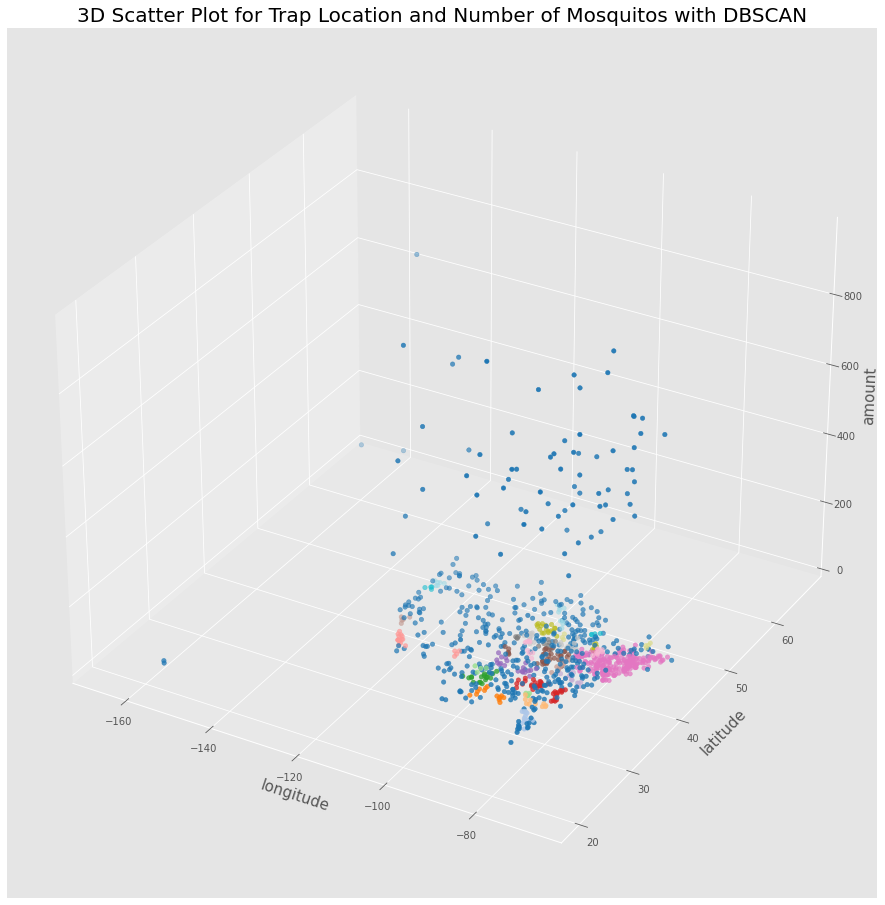

In [519]:
# Clustering using DBSCAN
cl_3d = DBSCAN(min_samples=4, eps=0.015)
plot_cluster_3d(location_grp, cl_3d, 'long', 'lat', 'amt')

In [520]:
# numbers of unique cluster
location_grp['cluster'].nunique()

44

In [524]:
# check min and max cluster
location_grp['cluster'].min(), location_grp['cluster'].max()

(-1, 42)

In [525]:
# replace cluster -1 with max cluster + 1
location_grp['cluster'] = [location_grp['cluster'].max()+1 if x == -1 else x for x in location_grp['cluster']]

In [526]:
# check the min and max cluster
location_grp['cluster'].min(), location_grp['cluster'].max()

(0, 43)

In [530]:
location_grp.head()

,lat,long,amt,is_fraud,cluster
0,20.0271,-155.3697,56.714957,1.0,43
1,20.0827,-155.4880,62.384971,0.0,43
2,24.6557,-81.3824,56.458731,1.0,43
3,26.1184,-81.7361,62.354625,1.0,0
4,26.3304,-81.5871,74.157620,1.0,0


In [531]:
# Merge the cluster back to train_cleaned as new Feature
train_cleaned = pd.merge(train_cleaned, location_grp[['lat','long','cluster']], on=['lat','long'])

In [532]:
train_cleaned.head()

,trans_datetime,cc_num,merchant,category,amt,is_male,street,city,state,zip,...,min_merch_last_7d,min_merch_last_14d,min_merch_last_30d,max_merch_last_24h,max_merch_last_7d,max_merch_last_14d,max_merch_last_30d,internet_transaction,customer_segment,cluster
0,2019-01-01 12:47:15,60416207185,"fraud_Jones,_Sawayn_and_Romaguera",misc_net,7.27,0,9886 Anita Drive,Fort_Washakie,WY,82514,...,7.27,7.27,7.27,7.27,7.27,7.27,7.27,1,Medium_Value_Cust,43
1,2019-01-02 08:44:57,60416207185,fraud_Berge_LLC,gas_transport,52.94,0,9886 Anita Drive,Fort_Washakie,WY,82514,...,52.94,52.94,52.94,79.01,79.39,79.39,79.39,0,Medium_Value_Cust,43
2,2019-01-02 08:47:36,60416207185,fraud_Luettgen_PLC,gas_transport,82.08,0,9886 Anita Drive,Fort_Washakie,WY,82514,...,47.10,47.10,47.10,82.08,82.08,82.08,82.08,0,Medium_Value_Cust,43
3,2019-01-02 12:38:14,60416207185,fraud_Daugherty_LLC,kids_pets,34.79,0,9886 Anita Drive,Fort_Washakie,WY,82514,...,26.85,26.85,26.85,99.84,99.84,99.84,99.84,0,Medium_Value_Cust,43
4,2019-01-02 13:10:46,60416207185,fraud_Beier_and_Sons,home,27.18,0,9886 Anita Drive,Fort_Washakie,WY,82514,...,24.46,24.46,24.46,173.49,173.49,173.49,173.49,0,Medium_Value_Cust,43


In [533]:
train_cleaned.columns

Index(['trans_datetime', 'cc_num', 'merchant', 'category', 'amt', 'is_male',
       'street', 'city', 'state', 'zip', 'lat', 'long', 'city_pop', 'job',
       'trans_num', 'merch_lat', 'merch_long', 'is_fraud', 'name',
       'coords_ori', 'coords_merch', 'trans_year', 'trans_month', 'trans_week',
       'trans_day', 'trans_hour', 'trans_minute', 'trans_dayofweek', 'age',
       'distance', 'amt_group', 'age_group', 'pre_amt', 'cum_sum', 'amt_diff',
       'pct_change', 'amt_avg', 'diff_minutes_pre_trans', 'diff_distance',
       'trans_last_1h', 'trans_last_24h', 'trans_last_7d', 'trans_last_30d',
       'avg_last_1h', 'avg_last_24h', 'avg_last_7d', 'avg_last_30d',
       'min_last_1h', 'min_last_24h', 'min_last_7d', 'min_last_30d',
       'max_last_1h', 'max_last_24h', 'max_last_7d', 'max_last_30d',
       'merch_last_24h', 'merch_last_7d', 'merch_last_14d', 'merch_last_30d',
       'avg_merch_last_24h', 'avg_merch_last_7d', 'avg_merch_last_14d',
       'avg_merch_last_30d', 'min_mer

In [ ]:
xx

### Network Analysis [work in progress]

In [328]:
train_cleaned.columns

Index(['trans_datetime', 'cc_num', 'merchant', 'category', 'amt', 'gender',
       'street', 'city', 'state', 'zip', 'lat', 'long', 'city_pop', 'job',
       'trans_num', 'merch_lat', 'merch_long', 'is_fraud', 'name',
       'coords_ori', 'coords_merch', 'trans_year', 'trans_month', 'trans_week',
       'trans_day', 'trans_hour', 'trans_minute', 'trans_dayofweek', 'age',
       'distance', 'amt_group', 'age_group'],
      dtype='object')

In [329]:
# # NetworkX to create and work with Networks
# import networkx as nx

# # Pyvis to visualise the graps from Networkx
# from pyvis.network import Network

# import itertools

In [330]:
# test_cc['cc_num'].unique()[0]

571365235126

In [331]:
# test_cc['category'].nunique()

14

In [332]:
# test_cc.groupby('category')['amt'].mean()

category
entertainment      53.016702
food_dining        32.624734
gas_transport      60.031959
grocery_net        50.435701
grocery_pos       101.565018
health_fitness     54.763298
home               49.042637
kids_pets          47.775639
misc_net           78.126774
misc_pos           61.675097
personal_care      51.390806
shopping_net       44.198233
shopping_pos       88.341517
travel             94.077193
Name: amt, dtype: float64

In [333]:
# merchant_list = test_cc.loc[test_cc['cc_num']==571365235126, 'category'].unique()
# merchant_list

array(['grocery_net', 'health_fitness', 'shopping_net', 'shopping_pos',
       'gas_transport', 'kids_pets', 'misc_net', 'grocery_pos', 'home',
       'misc_pos', 'entertainment', 'personal_care', 'travel',
       'food_dining'], dtype=object)

In [334]:
# check = []
# check.append(('1','2'))

In [335]:
# check.append(('1','2'))
# check

[('1', '2'), ('1', '2')]

In [336]:
# combi_list = []
# for mer in merchant_list:
#     combi = ('cc1',mer)
#     combi_list.append(combi)

In [338]:
# g = nx.Graph()

In [339]:
# g.add_edge('cc1','grocery_net')
# g.add_edge('cc1','health_fitness')
# g.add_edge('cc1','travel')
# g.add_edge('cc2','grocery_net')
# g.add_edge('cc2','personal_care')
# g.add_edge('cc3','grocery_net')
# g.add_edge('cc3','personal_care')

In [340]:
# g.remove_edge('cc2','grocery_net')
# g.remove_edge('cc2','personal_care')
# g.remove_edge('cc3','grocery_net')
# g.remove_edge('cc3','personal_care')

In [341]:
# list(g.edges())

[('cc1', 'grocery_net'), ('cc1', 'health_fitness'), ('cc1', 'travel')]

In [342]:
# g.remove_edges_from(list(g.edges()))
# g.remove_node('cc2')
# g.remove_node('cc3')

In [343]:
# g.add_edges_from(combi_list)

In [344]:
# pnet = Network(notebook=True)
# pnet.from_nx(g)
# pnet.show('g1.html')

In [345]:
# # Network Analysis
# merchant_edges = []
# network_list = []

# for group in test_cc['cc_num'].unique():

#     # Find all the project members belonging to the group
#     cc_merchant = test_cc.loc[test_cc['cc_num']==group, 'merchant'].values.tolist()
#     # print(cc_merchant)

#     # Convert the list of project members to a 2x2 grouping
#     # This is the format NetworkX requires to build a graph
#     merchant_edges += list(itertools.combinations(cc_merchant, 2))
#     # print(merchant_edges)
    


# # Draw the network
# cc_net = nx.Graph()
# cc_net.add_edges_from(merchant_edges)
# network_list.append(cc_net)    

# cc_net = Network(notebook=True, width='100%')
# cc_net.from_nx(network_list[0])
# # cc_net.show('g1.html')

In [346]:
# test_cc.set_index('trans_datetime').resample('M')['amt'].mean()

In [347]:
# plt.figure(figsize=(12,8))
# plt.plot(test_cc.set_index('trans_datetime').resample('M')['amt'].count(), label='Amount')

In [348]:
# train_cleaned.groupby(['is_fraud','trans_year','trans_hour']).agg({'is_fraud':'count','amt':'mean'})

is_fraud         amt
is_fraud trans_year trans_hour                      
0        2019       0              29817   74.887874
                    1              30137   75.259894
                    2              29950   76.403257
                    3              29991   75.421427
                    4              29931   75.545899
...                                  ...         ...
1        2020       19                31  606.839355
                    20                17  605.252941
                    21                23  635.643478
                    22               594  671.969815
                    23               573  627.663874

[96 rows x 2 columns]

# Stop at Here

In [173]:
# train_cleaned['date'] = train_cleaned['trans_year'].astype(str) + '-' + train_cleaned['trans_month'].astype(str) + '-' +\
# train_cleaned['trans_day'].astype(str)

In [ ]:
# train_cleaned[(train_cleaned['cc_num'] == 3556613125071656)&
#               (train_cleaned['trans_day']==26)&
#               (train_cleaned['trans_month']==4)
#              ].sort_values(['is_fraud', 'date'])[['trans_datetime','amt','is_fraud','diff_pre_trans_datetime']]

In [ ]:
# print(train_cleaned['date'].values[0])

In [ ]:
# train_cleaned[train_cleaned['date'] == dt('2019-01-01')]

In [ ]:
# plt.figure(figsize=(10,10))
# sns.histplot(data = train_cleaned.groupby(['is_fraud','cc_num','date'])['diff_pre_trans_datetime'].count().reset_index()[train_cleaned.groupby(['is_fraud','cc_num','date'])['diff_pre_trans_datetime'].count().reset_index()['is_fraud']==1],
#             x='diff_pre_trans_datetime', hue='is_fraud');

In [ ]:
# sns.histplot(ax= ax[0],data= train_cleaned[train_cleaned['is_fraud']==0] , x='distance')
# ax[0].set_title('Barplot of Distance (Not Fraud)')
# sns.histplot(ax= ax[1],data= train_cleaned[train_cleaned['is_fraud']==1] , x='distance')
# ax[1].set_title('Barplot of Distance (Is Fraud)');

In [ ]:
# # explore last hour transactions
# fig, ax = plt.subplots(1,2, figsize=(15,5))
# sns.histplot(ax=ax[0], data= train_cleaned['diff_pre_trans_datetime'])
# sns.boxplot(ax= ax[1], data= train_cleaned, x='diff_pre_trans_datetime');

In [ ]:
# sns.scatterplot(data=train_cleaned, x='diff_distance', y='diff_pre_trans_datetime_minute', hue='is_fraud');

In [ ]:
# sns.histplot(train_cleaned[train_cleaned['is_fraud']==1]['diff_pre_trans_datetime_minute']);

In [ ]:
# sns.scatterplot(data=train_cleaned[train_cleaned['is_fraud']==1], x='amt_diff', y='diff_pre_trans_datetime_minute');

In [181]:
train_cleaned['cc_num'][0]

60416207185

In [182]:
train_cleaned.set_index('trans_datetime').loc[train_cleaned.set_index('trans_datetime')['cc_num'] == train_cleaned['cc_num'][10]]['is_fraud'].value_counts()

0    1509
1       9
Name: is_fraud, dtype: int64

In [183]:
train_cleaned[(train_cleaned['is_fraud'] == 1) & (train_cleaned['cc_num']==train_cleaned['cc_num'][10])]

,trans_datetime,cc_num,merchant,category,amt,is_male,street,city,state,zip,...,trans_last_7_day,trans_last_30_day,avg_last_1_hour,avg_last_24_hour,avg_last_7_day,avg_last_30_day,diff_pre_trans_datetime,diff_pre_trans_datetime_minute,diff_distance,date
115,2019-03-01 01:32:53,60416207185,fraud_Marks_Inc,gas_transport,13.17,0,9886 Anita Drive,Fort_Washakie,WY,82514,...,23.0,60.0,13.170000,51.824000,51.701304,47.910833,0.266979,384.45,127.986445,2019-3-1
116,2019-03-01 02:42:25,60416207185,fraud_Cummings_LLC,gas_transport,11.74,0,9886 Anita Drive,Fort_Washakie,WY,82514,...,24.0,61.0,11.740000,45.143333,50.036250,47.317869,0.048287,69.53,112.395667,2019-3-1
117,2019-03-01 23:06:58,60416207185,fraud_Labadie_LLC,personal_care,19.16,0,9886 Anita Drive,Fort_Washakie,WY,82514,...,18.0,62.0,19.160000,14.690000,44.395000,46.863710,0.850382,1224.55,69.127523,2019-3-1
118,2019-03-02 22:10:38,60416207185,fraud_Barrows_PLC,shopping_pos,830.06,0,9886 Anita Drive,Fort_Washakie,WY,82514,...,17.0,63.0,830.060000,424.610000,94.782353,59.295397,0.960880,1383.67,147.694746,2019-3-2
119,2019-03-02 22:10:59,60416207185,"fraud_Windler,_Goodwin_and_Kovacek",home,261.79,0,9886 Anita Drive,Fort_Washakie,WY,82514,...,18.0,64.0,545.925000,370.336667,104.060556,62.459375,0.000243,0.35,127.076302,2019-3-2
120,2019-03-02 23:01:54,60416207185,fraud_Douglas-White,entertainment,594.09,0,9886 Anita Drive,Fort_Washakie,WY,82514,...,19.0,65.0,561.980000,426.275000,129.851579,70.638308,0.035359,50.92,40.921544,2019-3-2
121,2019-03-02 23:08:08,60416207185,"fraud_Turner,_Ziemann_and_Lehner",food_dining,130.08,0,9886 Anita Drive,Fort_Washakie,WY,82514,...,20.0,66.0,454.005000,454.005000,129.863000,71.538939,0.004329,6.23,79.778872,2019-3-2
122,2019-03-02 23:11:08,60416207185,fraud_Parker-Kunde,personal_care,20.41,0,9886 Anita Drive,Fort_Washakie,WY,82514,...,21.0,67.0,248.193333,367.286000,124.650952,70.775821,0.002083,3.00,105.802774,2019-3-2
123,2019-03-02 23:43:40,60416207185,fraud_Berge-Hills,kids_pets,19.23,0,9886 Anita Drive,Fort_Washakie,WY,82514,...,22.0,68.0,190.952500,309.276667,119.859091,70.017794,0.022593,32.53,106.554641,2019-3-2


In [184]:
train_cleaned.set_index('trans_datetime').loc[train_cleaned.set_index('trans_datetime')['cc_num'] == train_cleaned['cc_num'][0]]

,cc_num,merchant,category,amt,is_male,street,city,state,zip,lat,...,trans_last_7_day,trans_last_30_day,avg_last_1_hour,avg_last_24_hour,avg_last_7_day,avg_last_30_day,diff_pre_trans_datetime,diff_pre_trans_datetime_minute,diff_distance,date
trans_datetime,,,,,,,,,,,,,,,,,,,,,
2019-01-01 12:47:15,60416207185,"fraud_Jones,_Sawayn_and_Romaguera",misc_net,7.27,0,9886 Anita Drive,Fort_Washakie,WY,82514,43.0048,...,1.0,1.0,7.270,7.2700,7.270000,7.270000,0.000000,0.00,0.000000,2019-1-1
2019-01-02 08:44:57,60416207185,fraud_Berge_LLC,gas_transport,52.94,0,9886 Anita Drive,Fort_Washakie,WY,82514,43.0048,...,2.0,2.0,52.940,30.1050,30.105000,30.105000,0.831736,1197.70,224.614202,2019-1-2
2019-01-02 08:47:36,60416207185,fraud_Luettgen_PLC,gas_transport,82.08,0,9886 Anita Drive,Fort_Washakie,WY,82514,43.0048,...,3.0,3.0,67.510,47.4300,47.430000,47.430000,0.001840,2.65,105.117359,2019-1-2
2019-01-02 12:38:14,60416207185,fraud_Daugherty_LLC,kids_pets,34.79,0,9886 Anita Drive,Fort_Washakie,WY,82514,43.0048,...,4.0,4.0,34.790,44.2700,44.270000,44.270000,0.160162,230.63,88.111679,2019-1-2
2019-01-02 13:10:46,60416207185,fraud_Beier_and_Sons,home,27.18,0,9886 Anita Drive,Fort_Washakie,WY,82514,43.0048,...,5.0,5.0,30.985,49.2475,40.852000,40.852000,0.022593,32.53,132.827928,2019-1-2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-06-20 08:14:58,60416207185,"fraud_Greenholt,_Jacobi_and_Gleason",gas_transport,66.20,0,9886 Anita Drive,Fort_Washakie,WY,82514,43.0048,...,23.0,88.0,65.490,45.6000,53.925217,58.855114,0.013125,18.90,120.378311,2020-6-20
2020-06-20 15:14:35,60416207185,fraud_Stoltenberg-Beatty,shopping_pos,3.74,0,9886 Anita Drive,Fort_Washakie,WY,82514,43.0048,...,22.0,88.0,3.740,35.1350,56.068636,58.168750,0.291400,419.62,68.015331,2020-6-20
2020-06-20 20:18:04,60416207185,"fraud_Towne,_Greenholt_and_Koepp",shopping_net,9.42,0,9886 Anita Drive,Fort_Washakie,WY,82514,43.0048,...,22.0,88.0,9.420,36.0350,56.415455,56.589545,0.210752,303.48,17.700320,2020-6-20


In [185]:
train_cleaned.head(2)

,trans_datetime,cc_num,merchant,category,amt,is_male,street,city,state,zip,...,trans_last_7_day,trans_last_30_day,avg_last_1_hour,avg_last_24_hour,avg_last_7_day,avg_last_30_day,diff_pre_trans_datetime,diff_pre_trans_datetime_minute,diff_distance,date
0,2019-01-01 12:47:15,60416207185,"fraud_Jones,_Sawayn_and_Romaguera",misc_net,7.27,0,9886 Anita Drive,Fort_Washakie,WY,82514,...,1.0,1.0,7.27,7.270,7.270,7.270,0.000000,0.0,0.000000,2019-1-1
1,2019-01-02 08:44:57,60416207185,fraud_Berge_LLC,gas_transport,52.94,0,9886 Anita Drive,Fort_Washakie,WY,82514,...,2.0,2.0,52.94,30.105,30.105,30.105,0.831736,1197.7,224.614202,2019-1-2


In [186]:
train_cleaned.set_index('trans_datetime')[train_cleaned.set_index('trans_datetime')['cc_num']==train_cleaned['cc_num'][10]].\
resample('D').agg({'diff_pre_trans_datetime':['mean','count']}).sort_values([('diff_pre_trans_datetime','mean')]).head(10)

diff_pre_trans_datetime      
                                  mean count
trans_datetime                              
2019-01-01                    0.000000     1
2019-06-11                    0.023970     1
2019-09-12                    0.069711     1
2019-03-03                    0.090995     1
2019-12-20                    0.095239     8
2019-12-22                    0.108189    10
2019-11-18                    0.113785     8
2019-05-19                    0.113993     8
2019-07-08                    0.114716     8
2019-12-15                    0.120460    11

In [187]:
train_cleaned.set_index('trans_datetime')[train_cleaned.set_index('trans_datetime')['cc_num']==train_cleaned['cc_num'][10]].\
resample('D')[['diff_pre_trans_datetime','amt']].mean().sort_values('diff_pre_trans_datetime',ascending=True).head(20)

,diff_pre_trans_datetime,amt
trans_datetime,,
2019-01-01,0.000000,7.270000
2019-06-11,0.023970,57.460000
2019-09-12,0.069711,72.980000
2019-03-03,0.090995,54.390000
2019-12-20,0.095239,39.886250
2019-12-22,0.108189,47.650000
2019-11-18,0.113785,31.320000
2019-05-19,0.113993,33.355000
2019-07-08,0.114716,35.018750


In [188]:
train_cleaned[(train_cleaned['cc_num']==train_cleaned['cc_num'][10])].\
groupby(['trans_year','trans_month','trans_day']).agg({'amt':['mean','count']})

amt      
                                      mean count
trans_year trans_month trans_day                
2019       1           1            7.2700     1
                       2           49.2475     4
                       3            7.6500     2
                       4           71.9250     2
                       5           55.0900     2
...                                    ...   ...
2020       6           17           2.7700     1
                       18         110.7425     4
                       19           5.8200     1
                       20          30.4060     5
                       21          61.9300     1

[498 rows x 2 columns]

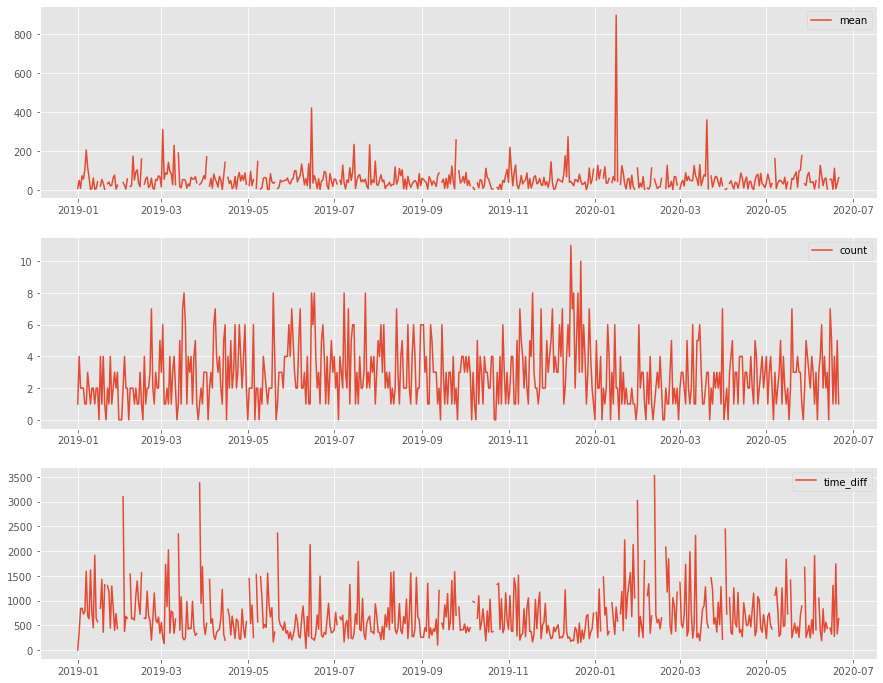

In [190]:
fig, axes = plt.subplots(nrows=3, figsize=(15,12))
axes[0].plot(train_cleaned.set_index('trans_datetime')[train_cleaned.set_index('trans_datetime')['cc_num']==train_cleaned['cc_num'][10]].\
resample('D')['amt'].mean(), 
             label='mean')
axes[0].legend()

axes[1].plot(train_cleaned.set_index('trans_datetime')[train_cleaned.set_index('trans_datetime')['cc_num']==train_cleaned['cc_num'][10]].\
resample('D')['amt'].count(), 
             label='count')
axes[1].legend()

axes[2].plot(train_cleaned.set_index('trans_datetime')[train_cleaned.set_index('trans_datetime')['cc_num']==train_cleaned['cc_num'][10]].\
resample('D')['diff_pre_trans_datetime_minute'].mean(), 
             label='time_diff')
axes[2].legend();

C:\Users\chua_\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning:

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.

C:\Users\chua_\anaconda3\lib\site-packages\numpy\lib\nanfunctions.py:1368: RuntimeWarning:

All-NaN slice encountered



<AxesSubplot:xlabel='amt'>

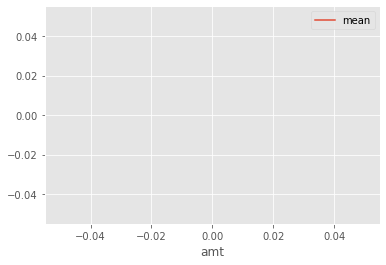

In [191]:
sns.lineplot(train_cleaned.set_index('trans_datetime')[train_cleaned.set_index('trans_datetime')['cc_num']==train_cleaned['cc_num'][10]].\
resample('D')['amt'].mean(), 
             label='mean')

In [ ]:
xxx

### Export Data

In [534]:
# # save to pickle file
# train_cleaned.to_pickle('../datasets/train_final.pkl')